In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [2]:
from src.missing_data_exploration.sub_modules.evaluation_models import eval_LR, eval_svm, eval_rf
from src.modules.data_preprocessing import load_data
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from src.missing_data_exploration.sub_modules.ms_simulate.mcar_simulate import simulate_nan_mcar
from src.missing_data_exploration.sub_modules.ms_simulate.mar_simulate import (
    simulate_nan_mar_quantile, simulate_nan_mar_sigmoid, simulate_nan_mary_quantile, simulate_nan_mary_sigmoid
)
from config import ROOT_DIR, settings
import os
import json
from dython.nominal import correlation_ratio
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.missing_data_exploration.sub_modules.ms_simulate.ms_pattern_simulate import (
    simulate_nan_patterns_mar_pyamp, simulate_nan_patterns_mar_quantile, simulate_nan_patterns_mar_sigmoid
)

In [4]:
from src.fed_imp.sub_modules.missing_simulate.missing_adder import simulate_nan
from src.modules.iterative_imputation.local_imputer import LocalIterativeImputer

## Main Functions

In [5]:
def eval_base(X_train_ms, y_train, X_test, y_test, config, seed):

    clf_seed = seed    

    X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
    min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0) + 0.001
    X_train_imp_iter = IterativeImputer(
        random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
    ).fit_transform(X_train_ms)
    # X_train_imp_iter = IterativeImputer(
    #     random_state=seed, max_iter=50, 
    # ).fit_transform(X_train_ms)
    # X_train_imp_iter = LocalIterativeImputer(
    #     seed=seed, max_iter=50,
    # ).fit_transform(X_train_ms)


    #print("Simple Imputer")
    score_simple_lr = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
    score_simple_svm = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
    score_iter_lr = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
    score_iter_svm = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
    
    return score_simple_lr, score_simple_svm, score_iter_lr, score_iter_svm

### Evaluation MCAR

In [6]:
def evaluation_mcar(
        train_data, test_data, config, col_option, ms_ratios, r_seed = 21, n_rounds = 100, name = 'default'
    ):
    
    clf_seed = r_seed
    res = {'simple_lr': {}, 'simple_svm': {}, 'iter_lr': {}, 'iter_svm': {}}

    if col_option == 'all':
        cols = list(range(train_data.shape[1]-1))
    elif col_option == 'important':
        cols = config['important_features_idx']
    else:
        raise NotImplemented
    
    # evaluation on full data
    X_train = train_data.drop(config['target'], axis=1).values
    y_train = train_data[config['target']].values
    X_test = test_data.drop(config['target'], axis=1).values
    y_test = test_data[config['target']].values

    lr_full = eval_LR(X_train, y_train, X_test, y_test, seed=clf_seed)
    svm_full = eval_svm(X_train, y_train, X_test, y_test, seed=clf_seed)
    res['simple_lr'][0] = [lr_full]
    res['simple_svm'][0] = [svm_full]
    res['iter_lr'][0] = [lr_full]
    res['iter_svm'][0] = [svm_full]

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            X_train_ms = simulate_nan_mcar(X_train, cols, ms_ratio, seed)
            # ret = simulate_nan(train_data.values, cols, ms_ratio,'mcar', 1.0, seed)
            # X_train_ms = ret['train_data_ms'][:, :-1]
            
            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, clf_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mcar_col_{col_option}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

### Evaluate MAR

In [7]:
def evaluation_mar(
        train_data, test_data, config, cols, mar_option, ms_ratios, ms_func, r_seed = 21, n_rounds = 100, name = 'default'
    ):
    
    clf_seed = r_seed
    res = {'simple_lr': {}, 'simple_svm': {}, 'iter_lr': {}, 'iter_svm': {}}
    
    # evaluation on full data
    X_train = train_data.drop(config['target'], axis=1).values
    y_train = train_data[config['target']].values
    X_test = test_data.drop(config['target'], axis=1).values
    y_test = test_data[config['target']].values

    lr_full = eval_LR(X_train, y_train, X_test, y_test, seed=clf_seed)
    svm_full = eval_svm(X_train, y_train, X_test, y_test, seed=clf_seed)
    res['simple_lr'][0] = [lr_full]
    res['simple_svm'][0] = [svm_full]
    res['iter_lr'][0] = [lr_full]
    res['iter_svm'][0] = [svm_full]

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            if mar_option == 'quantile_strict':
                X_train_ms = simulate_nan_mar_quantile(X_train, cols, ms_ratio, ms_func, obs=True, strict = True, seed = seed)
            elif mar_option == 'quantile_nonstrict':
                X_train_ms = simulate_nan_mar_quantile(X_train, cols, ms_ratio, ms_func, obs=True, strict = False, seed = seed)
            elif mar_option == 'sigmoid_strict':
                X_train_ms = simulate_nan_mar_sigmoid(X_train, cols, ms_ratio, ms_func, obs=True, k ='all', strict = True, seed = seed)
            elif mar_option == 'sigmoid_nonstrict':
                X_train_ms = simulate_nan_mar_sigmoid(X_train, cols, ms_ratio, ms_func, obs=True, k = 'all', strict = False, seed = seed)
            elif mar_option == 'quantile_strict_nobs':
                X_train_ms = simulate_nan_mar_quantile(X_train, cols, ms_ratio, ms_func, obs=False, strict = True, seed = seed)
            elif mar_option == 'quantile_nonstrict_nobs':
                X_train_ms = simulate_nan_mar_quantile(X_train, cols, ms_ratio, ms_func, obs=False, strict = False, seed = seed)
            elif mar_option == 'sigmoid_strict_nobs':
                X_train_ms = simulate_nan_mar_sigmoid(X_train, cols, ms_ratio, ms_func, obs=False, k = 'all', strict = True, seed = seed)
            elif mar_option == 'sigmoid_nonstrict_nobs':
                X_train_ms = simulate_nan_mar_sigmoid(X_train, cols, ms_ratio, ms_func, obs=False, k = 'all', strict = False, seed = seed)
            else:
                raise ValueError("mar_option not supported")

            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, clf_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mar_{mar_option}_{ms_func}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

### Evaluation MARY

In [8]:
def evaluation_mary(
        train_data, test_data, config, cols, mary_option, ms_ratios, ms_func, r_seed = 21, n_rounds = 100, name = 'default'
    ):
    
    clf_seed = r_seed
    res = {'simple_lr': {}, 'simple_svm': {}, 'iter_lr': {}, 'iter_svm': {}}
    
    # evaluation on full data
    X_train = train_data.drop(config['target'], axis=1).values
    y_train = train_data[config['target']].values
    X_test = test_data.drop(config['target'], axis=1).values
    y_test = test_data[config['target']].values

    lr_full = eval_LR(X_train, y_train, X_test, y_test, seed=clf_seed)
    svm_full = eval_svm(X_train, y_train, X_test, y_test, seed=clf_seed)
    res['simple_lr'][0] = [lr_full]
    res['simple_svm'][0] = [svm_full]
    res['iter_lr'][0] = [lr_full]
    res['iter_svm'][0] = [svm_full]

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            if mary_option == 'quantile_strict':
                train_ms = simulate_nan_mary_quantile(train_data.values, cols, ms_ratio, ms_func, strict = True, seed = seed)
            elif mary_option == 'quantile_nonstrict':
                train_ms = simulate_nan_mary_quantile(train_data.values, cols, ms_ratio, ms_func, strict = False, seed = seed)
            elif mary_option == 'sigmoid_strict':
                train_ms = simulate_nan_mary_sigmoid(train_data.values, cols, ms_ratio, ms_func, strict = True, seed = seed)
            elif mary_option == 'sigmoid_nonstrict':
                train_ms = simulate_nan_mary_sigmoid(train_data.values, cols, ms_ratio, ms_func, strict = False, seed = seed)
            else:
                raise ValueError("mar_option not supported")
            X_train_ms = train_ms[:, :-1]

            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, clf_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mary_{mary_option}_{ms_func}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

### Evaluate Patterns

In [9]:
def evaluation_mar_pattern(
        train_data, test_data, config, ms_patterns, mar_option, ms_ratios, ms_func, r_seed = 21, n_rounds = 100, name = 'default'
    ):
    
    clf_seed = r_seed
    res = {'simple_lr': {}, 'simple_svm': {}, 'iter_lr': {}, 'iter_svm': {}}
    
    # evaluation on full data
    X_train = train_data.drop(config['target'], axis=1).values
    y_train = train_data[config['target']].values
    X_test = test_data.drop(config['target'], axis=1).values
    y_test = test_data[config['target']].values

    lr_full = eval_LR(X_train, y_train, X_test, y_test, seed=clf_seed)
    svm_full = eval_svm(X_train, y_train, X_test, y_test, seed=clf_seed)
    res['simple_lr'][0] = [lr_full]
    res['simple_svm'][0] = [svm_full]
    res['iter_lr'][0] = [lr_full]
    res['iter_svm'][0] = [svm_full]

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            if mar_option == 'quantile_strict':
                X_train_ms = simulate_nan_patterns_mar_quantile(X_train, ms_patterns, ms_ratio, ms_func, strict = True, seed = seed)
            elif mar_option == 'quantile_nonstrict':
                X_train_ms = simulate_nan_patterns_mar_quantile(X_train, ms_patterns, ms_ratio, ms_func, strict = False, seed = seed)
            elif mar_option == 'sigmoid_strict':
                X_train_ms = simulate_nan_patterns_mar_sigmoid(X_train, ms_patterns, ms_ratio, ms_func, k ='all', strict = True, seed = seed)
            elif mar_option == 'sigmoid_nonstrict':
                X_train_ms = simulate_nan_patterns_mar_sigmoid(X_train, ms_patterns, ms_ratio, ms_func, k = 'all', strict = False, seed = seed)
            elif mar_option == 'pyampute':
                X_train_ms = simulate_nan_patterns_mar_pyamp(X_train, ms_patterns, ms_ratio, ms_func, seed = seed)
            else:
                raise ValueError("mar_option not supported")

            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, clf_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_pattern_mar_{mar_option}_{ms_func}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

### Visualization

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt

def draw_plot_mcar(data_name):
    data = {}
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    file = f"{data_name}_mcar_col_all.json"
    with open(dir_name + file, 'r') as fp:
        data = json.load(fp)
    
    # draw plot
    fig, ax = plt.subplots(figsize=(6, 4))
    df = pd.DataFrame.from_dict(data, orient='index').T
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='accuracy')
    df = df.explode('accuracy')
    df.columns = ['missing_ratio', 'imputation_clf', 'accuracy']
    df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

    def error_bar(x):
        return np.min(x), np.max(x)

    sns.lineplot(x='missing_ratio', y='accuracy', hue='imputation_clf', data=df, markers = 'O', errorbar='sd', ax=ax)
    ax.set_title("mcar")
    ax.set_xlabel("Missing Ratio")
    ax.set_ylabel("Accuracy")
    plt.tight_layout()

def draw_plot_mar(data_name, option = 'mar'):
    # read files and data
    data = {}
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    ms_funcs = ['left', 'right']
    ms_options = ['quantile_strict', 'quantile_nonstrict', 'sigmoid_nonstrict']
    for ms_func in ms_funcs:
        for ms_option in ms_options:
            file = f"{data_name}_{option}_{ms_option}_{ms_func}.json"
            with open(dir_name + file, 'r') as fp:
                data[f"{ms_option}_{ms_func}"] = json.load(fp)
    
    # draw plot
    plots_names = [
        ['quantile_strict_left',  'quantile_nonstrict_left', 'sigmoid_nonstrict_left'],
        ['quantile_strict_right', 'quantile_nonstrict_right', 'sigmoid_nonstrict_right']
    ]
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), sharey=True, squeeze=False)
    for i in range(2):
        for j in range(3):
            plot_name = plots_names[i][j]
            # make dataframe
            plot_data = data[plot_name]
            df = pd.DataFrame.from_dict(plot_data, orient='index').T
            df.reset_index(inplace=True)
            df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='accuracy')
            df = df.explode('accuracy')
            df.columns = ['missing_ratio', 'imputation_clf', 'accuracy']
            df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

            def error_bar(x):
                return np.min(x), np.max(x)

            sns.lineplot(x='missing_ratio', y='accuracy', hue='imputation_clf', data=df, markers = 'O', errorbar='sd', ax=ax[i][j])
            ax[i][j].set_title(plot_name)
            ax[i][j].set_xlabel("Missing Ratio")
            ax[i][j].set_ylabel("Accuracy")
    plt.tight_layout()


def draw_plot_mar_pattern(data_name, option = 'mar', ms_option = 'sigmoid_nonstrict'):
    # read files and data
    data = {}
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/"
    ms_funcs = ['left', 'right']
    ms_options = [ms_option]
    patterns = ['', 'pattern_']
    for ms_func in ms_funcs:
        for ms_option in ms_options:
            for pattern in patterns:
                file = f"{data_name}_{pattern}{option}_{ms_option}_{ms_func}.json"
                with open(dir_name + file, 'r') as fp:
                    data[f"{pattern}{ms_option}_{ms_func}"] = json.load(fp)
    
    # draw plot
    plots_names = [
        [f'{ms_option}_left', f'pattern_{ms_option}_left', f'{ms_option}_right', f'pattern_{ms_option}_right']
    ]
    
    fig, ax = plt.subplots(1, 4, figsize=(11, 3), sharey=True, squeeze=False)
    for i in range(1):
        for j in range(4):
            plot_name = plots_names[i][j]
            # make dataframe
            plot_data = data[plot_name]
            df = pd.DataFrame.from_dict(plot_data, orient='index').T
            df.reset_index(inplace=True)
            df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='accuracy')
            df = df.explode('accuracy')
            df.columns = ['missing_ratio', 'imputation_clf', 'accuracy']
            df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

            def error_bar(x):
                return np.min(x), np.max(x)

            sns.lineplot(x='missing_ratio', y='accuracy', hue='imputation_clf', data=df, markers = 'O', errorbar='sd', ax=ax[i][j])
            ax[i][j].set_title(plot_name)
            ax[i][j].set_xlabel("Missing Ratio")
            ax[i][j].set_ylabel("Accuracy")
    plt.tight_layout()

<AxesSubplot: xlabel='missing_ratio', ylabel='accuracy'>

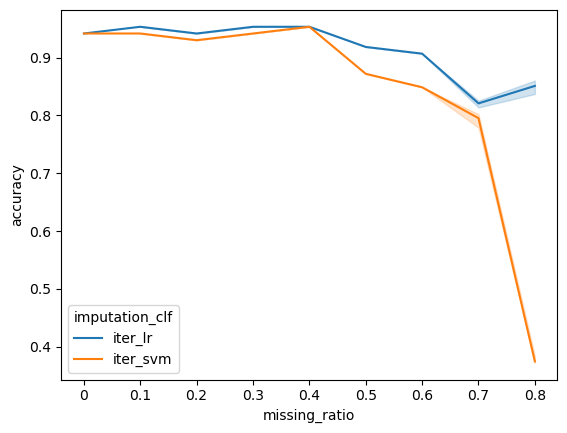

In [11]:
file_name = dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0322/" + "breast_mar_quantile_strict_left.json"
with open(file_name, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data, orient='index').T
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='accuracy')
df = df.explode('accuracy')
df.columns = ['missing_ratio', 'imputation_clf', 'accuracy']
df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

def error_bar(x):
    return np.min(x), np.max(x)

sns.lineplot(x='missing_ratio', y='accuracy', hue='imputation_clf', data=df, markers = 'O', errorbar=error_bar)

## All functions

In [12]:
def eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = 'iris'):
    # mcar
    #evaluation_mcar(train_data, test_data, config, 'all', missing_ratios, r_seed = r_seed, n_rounds = n_rounds, name = name)
    
    # mar
    evaluation_mar(train_data, test_data, config, cols_mar, 'sigmoid_nonstrict', missing_ratios, 
               ms_func = 'left', r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mar(train_data, test_data, config, cols_mar, 'sigmoid_nonstrict', missing_ratios, 
               ms_func = 'right', r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mar(train_data, test_data, config, cols_mar, 'quantile_strict', missing_ratios, 
               ms_func = 'left', r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mar(train_data, test_data, config, cols_mar, 'quantile_strict', missing_ratios, 
               ms_func = 'right', r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mar(train_data, test_data, config, cols_mar, 'quantile_nonstrict', missing_ratios, 
               ms_func = 'left', r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mar(train_data, test_data, config, cols_mar, 'quantile_nonstrict', missing_ratios, 
               ms_func = 'right', r_seed = r_seed, n_rounds = n_rounds, name = name)
    
    # mary
    evaluation_mary(train_data, test_data, config, cols_mary, 'sigmoid_nonstrict', missing_ratios, ms_func = 'left',
               r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mary(train_data, test_data, config, cols_mary, 'sigmoid_nonstrict', missing_ratios, ms_func = 'right',
               r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mary(train_data, test_data, config, cols_mary, 'quantile_strict', missing_ratios, ms_func = 'left',
               r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mary(train_data, test_data, config, cols_mary, 'quantile_strict', missing_ratios, ms_func = 'right',
               r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mary(train_data, test_data, config, cols_mary, 'quantile_nonstrict', missing_ratios, ms_func = 'left',
               r_seed = r_seed, n_rounds = n_rounds, name = name)
    evaluation_mary(train_data, test_data, config, cols_mary, 'quantile_nonstrict', missing_ratios, ms_func = 'right',
               r_seed = r_seed, n_rounds = n_rounds, name = name)

## Iris

In [18]:
data, config = load_data('iris')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

Index(['1', '2', '3', '4', '5'], dtype='object')
{'target': '5', 'important_features_idx': [2, 3, 0, 1], 'features_idx': [0, 1, 2, 3, 4], 'num_cols': 4, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(127, 5) (23, 5)


5    1.000000
3    0.970216
4    0.963761
1    0.786578
2    0.626004
dtype: float64

### Evaluation

In [19]:
data, config = load_data('iris')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_fearures_idx']
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = 'iris')

mr 0.1 Simple lr 0.87(0.0304) svm 0.93(0.0199) Iter lr 0.95(0.0261) svm 0.95(0.013)
mr 0.2 Simple lr 0.86(0.0507) svm 0.92(0.0361) Iter lr 0.96(0.0194) svm 0.96(0.013)
mr 0.3 Simple lr 0.79(0.0325) svm 0.89(0.0398) Iter lr 0.92(0.041) svm 0.95(0.0234)
mr 0.4 Simple lr 0.79(0.0174) svm 0.8(0.0278) Iter lr 0.9(0.0437) svm 0.97(0.0199)
mr 0.5 Simple lr 0.78(0.013) svm 0.79(0.0304) Iter lr 0.88(0.0478) svm 0.96(0.0304)
mr 0.6 Simple lr 0.79(0.013) svm 0.82(0.0494) Iter lr 0.76(0.0808) svm 0.9(0.0646)
mr 0.7 Simple lr 0.77(0.0174) svm 0.77(0.0199) Iter lr 0.78(0.041) svm 0.84(0.0992)
mr 0.8 Simple lr 0.76(0.0443) svm 0.81(0.0806) Iter lr 0.74(0.0658) svm 0.83(0.108)
mr 0.1 Simple lr 0.88(0.0552) svm 0.94(0.0199) Iter lr 0.96(1.11e-16) svm 0.95(0.013)
mr 0.2 Simple lr 0.84(0.0478) svm 0.91(0.0389) Iter lr 0.95(0.0531) svm 0.95(0.0174)
mr 0.3 Simple lr 0.78(0.0) svm 0.89(0.0401) Iter lr 0.92(0.0686) svm 0.95(0.0361)
mr 0.4 Simple lr 0.77(0.0174) svm 0.83(0.0858) Iter lr 0.83(0.0739) svm 0.95(

### MCAR

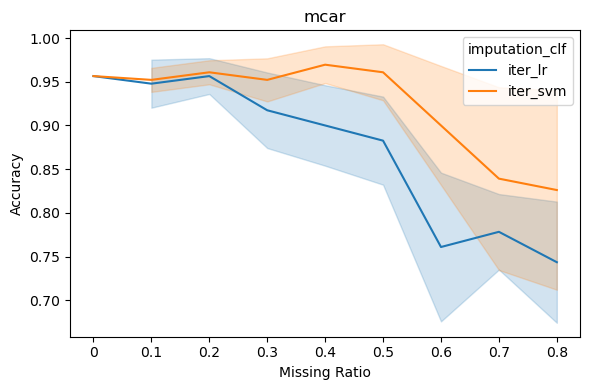

In [14]:
draw_plot_mcar('iris')

### MAR

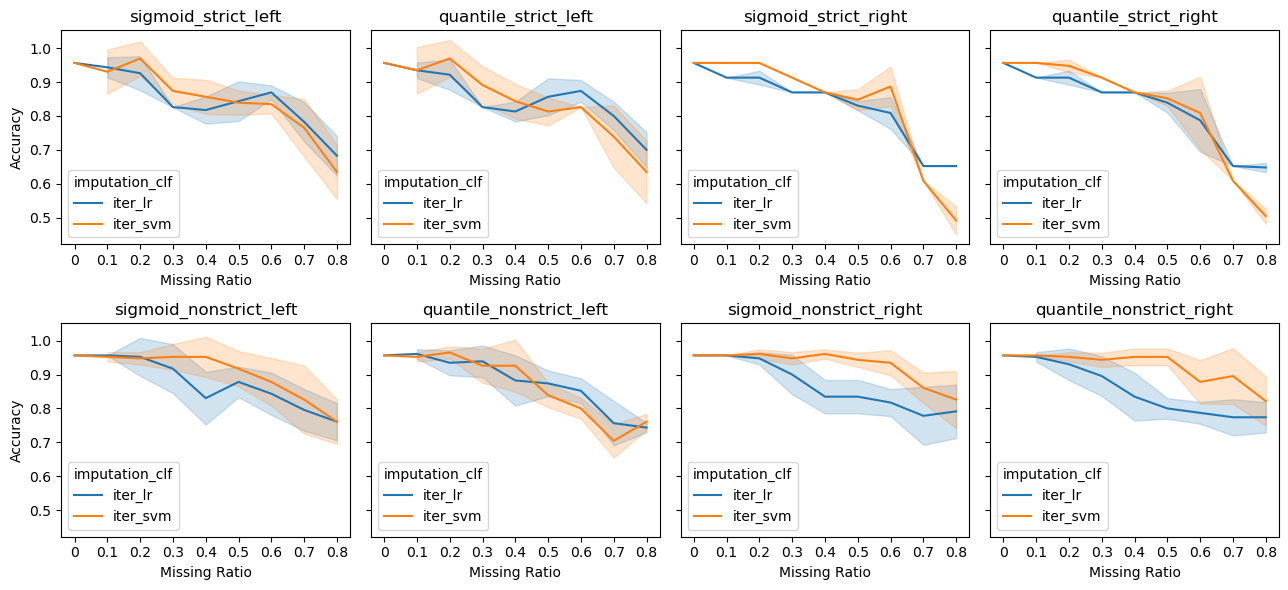

In [22]:
draw_plot_mar('iris', 'mar')

### MAR Pattern

In [16]:
cols = [0,1,2,3]
cols_list = []
cols_list.extend(list(itertools.combinations(cols, 3)))
cols_list.extend(list(itertools.combinations(cols, 2)))
cols_list.extend(list(itertools.combinations(cols, 1)))
ms_patterns = []
for cols in cols_list:
    ms_patterns.append(list(cols))
for ms_pattern in ms_patterns:
    print("pattern: {}".format(ms_pattern))
    evaluation_mar_pattern(train_data, test_data, config, [ms_pattern], 'sigmoid_nonstrict', [0.5], ms_func = 'right',
                   r_seed = 21, n_rounds = 10, name = 'iris')

pattern: [0, 1, 2]
mr 0.5 Simple lr 0.96(0.0494) svm 0.99(0.0174) Iter lr 0.96(0.0389) svm 0.93(0.0401)
pattern: [0, 1, 3]
mr 0.5 Simple lr 0.92(0.0379) svm 0.93(0.034) Iter lr 0.97(0.0278) svm 0.93(0.0213)
pattern: [0, 2, 3]
mr 0.5 Simple lr 0.8(0.0288) svm 0.92(0.041) Iter lr 0.78(0.0234) svm 0.95(0.0325)
pattern: [1, 2, 3]
mr 0.5 Simple lr 0.75(0.0754) svm 0.83(0.0972) Iter lr 0.87(0.0658) svm 0.94(0.0391)
pattern: [0, 1]
mr 0.5 Simple lr 0.97(0.0174) svm 0.96(1.11e-16) Iter lr 0.95(0.013) svm 0.97(0.0174)
pattern: [0, 2]
mr 0.5 Simple lr 0.93(0.0278) svm 0.97(0.0278) Iter lr 0.94(0.0288) svm 0.95(0.0174)
pattern: [0, 3]
mr 0.5 Simple lr 0.93(0.0292) svm 0.93(0.0288) Iter lr 0.97(0.0174) svm 0.95(0.013)
pattern: [1, 2]
mr 0.5 Simple lr 0.97(0.0543) svm 0.97(0.0278) Iter lr 0.97(0.0199) svm 0.93(0.0199)
pattern: [1, 3]
mr 0.5 Simple lr 0.91(0.0389) svm 0.93(0.0348) Iter lr 0.97(0.0199) svm 0.96(1.11e-16)
pattern: [2, 3]
mr 0.5 Simple lr 0.77(0.0639) svm 0.79(0.0639) Iter lr 0.85(0.06

In [39]:
cols = [0,1,2,3]
cols_list = []
cols_list.extend(list(itertools.combinations(cols, 3)))
cols_list.extend(list(itertools.combinations(cols, 2)))
cols_list.extend(list(itertools.combinations(cols, 1)))
ms_patterns = []
for cols in cols_list:
    ms_patterns.append(list(cols))
for ms_pattern in ms_patterns:
    print("pattern: {}".format(ms_pattern))
    evaluation_mar_pattern(train_data, test_data, config, [ms_pattern], 'sigmoid_nonstrict', [0.5], ms_func = 'left',
                   r_seed = 21, n_rounds = 10, name = 'iris')

pattern: [0, 1, 2]
mr 0.5 Simple lr 0.94(0.0199) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.96(1.11e-16)
pattern: [0, 1, 3]
mr 0.5 Simple lr 0.95(0.0174) svm 0.95(0.013) Iter lr 0.96(1.11e-16) svm 0.96(1.11e-16)
pattern: [0, 2, 3]
mr 0.5 Simple lr 0.77(0.0552) svm 0.88(0.107) Iter lr 0.85(0.0443) svm 0.88(0.0478)
pattern: [1, 2, 3]
mr 0.5 Simple lr 0.88(0.0174) svm 0.93(0.034) Iter lr 0.9(0.0577) svm 0.96(1.11e-16)
pattern: [0, 1]
mr 0.5 Simple lr 0.97(0.0174) svm 0.96(1.11e-16) Iter lr 0.96(0.013) svm 0.96(1.11e-16)
pattern: [0, 2]
mr 0.5 Simple lr 0.93(0.0199) svm 0.95(0.0234) Iter lr 0.95(0.0174) svm 0.95(0.013)
pattern: [0, 3]
mr 0.5 Simple lr 0.94(0.0288) svm 0.95(0.013) Iter lr 0.95(0.0325) svm 0.96(1.11e-16)
pattern: [1, 2]
mr 0.5 Simple lr 0.94(0.0199) svm 0.97(0.0199) Iter lr 0.97(0.0174) svm 0.96(1.11e-16)
pattern: [1, 3]
mr 0.5 Simple lr 0.96(1.11e-16) svm 0.95(0.013) Iter lr 0.96(1.11e-16) svm 0.96(1.11e-16)
pattern: [2, 3]
mr 0.5 Simple lr 0.83(0.0583) svm 0.88(0.118)

In [24]:
ms_patterns = [
    [0, 2, 3], [2, 3]
]

print("pattern: {}".format(ms_patterns))
evaluation_mar_pattern(train_data, test_data, config, ms_patterns, 'sigmoid_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'right',
                r_seed = 21, n_rounds = 10, name = 'iris')

pattern: [[0, 2, 3], [2, 3]]
mr 0.1 Simple lr 0.87(0.041) svm 0.95(0.0261) Iter lr 0.96(0.0275) svm 0.95(0.013)
mr 0.2 Simple lr 0.84(0.034) svm 0.93(0.0486) Iter lr 0.9(0.0557) svm 0.95(0.0261)
mr 0.3 Simple lr 0.83(0.0194) svm 0.87(0.0494) Iter lr 0.83(0.0639) svm 0.96(0.0275)
mr 0.4 Simple lr 0.8(0.0616) svm 0.84(0.0484) Iter lr 0.83(0.0668) svm 0.93(0.0437)
mr 0.5 Simple lr 0.78(0.0304) svm 0.84(0.0557) Iter lr 0.79(0.0609) svm 0.88(0.0754)
mr 0.6 Simple lr 0.8(0.034) svm 0.8(0.0391) Iter lr 0.8(0.0916) svm 0.88(0.0797)
mr 0.7 Simple lr 0.79(0.0325) svm 0.77(0.0391) Iter lr 0.81(0.0348) svm 0.85(0.0853)
mr 0.8 Simple lr 0.76(0.0401) svm 0.75(0.0278) Iter lr 0.73(0.0892) svm 0.77(0.0668)


In [27]:
ms_patterns = [
    [0, 2, 3]
]

print("pattern: {}".format(ms_patterns))
evaluation_mar_pattern(train_data, test_data, config, ms_patterns, 'sigmoid_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'left',
                r_seed = 21, n_rounds = 10, name = 'iris')

pattern: [[0, 2, 3]]
mr 0.1 Simple lr 0.92(0.041) svm 0.95(0.013) Iter lr 0.93(0.0391) svm 0.97(0.0174)
mr 0.2 Simple lr 0.86(0.0468) svm 0.96(0.0337) Iter lr 0.88(0.0391) svm 0.97(0.0398)
mr 0.3 Simple lr 0.81(0.034) svm 0.94(0.0437) Iter lr 0.87(0.0275) svm 0.93(0.0734)
mr 0.4 Simple lr 0.83(0.0389) svm 0.88(0.0585) Iter lr 0.86(0.0325) svm 0.9(0.0783)
mr 0.5 Simple lr 0.77(0.0552) svm 0.88(0.107) Iter lr 0.85(0.0443) svm 0.88(0.0478)
mr 0.6 Simple lr 0.74(0.0658) svm 0.77(0.0937) Iter lr 0.83(0.0507) svm 0.78(0.0531)
mr 0.7 Simple lr 0.73(0.0454) svm 0.8(0.0973) Iter lr 0.82(0.0598) svm 0.81(0.0398)
mr 0.8 Simple lr 0.74(0.0565) svm 0.77(0.0398) Iter lr 0.77(0.0478) svm 0.74(0.0933)


#### vis

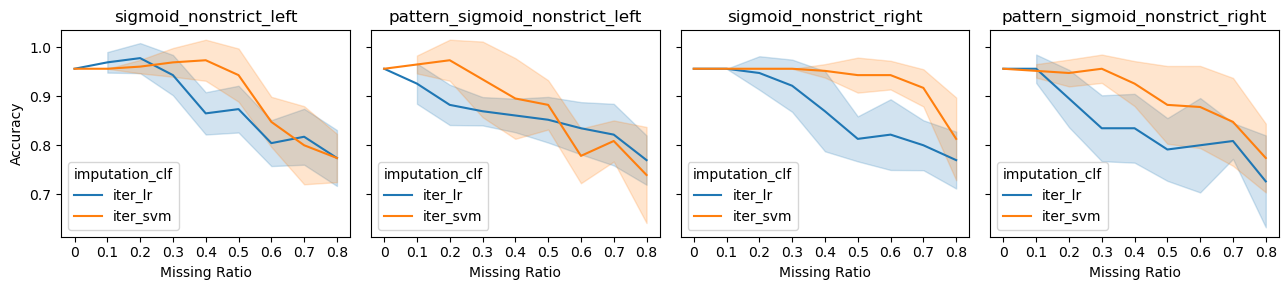

In [37]:
draw_plot_mar_pattern('iris', 'mar', 'sigmoid_nonstrict')

### MARY

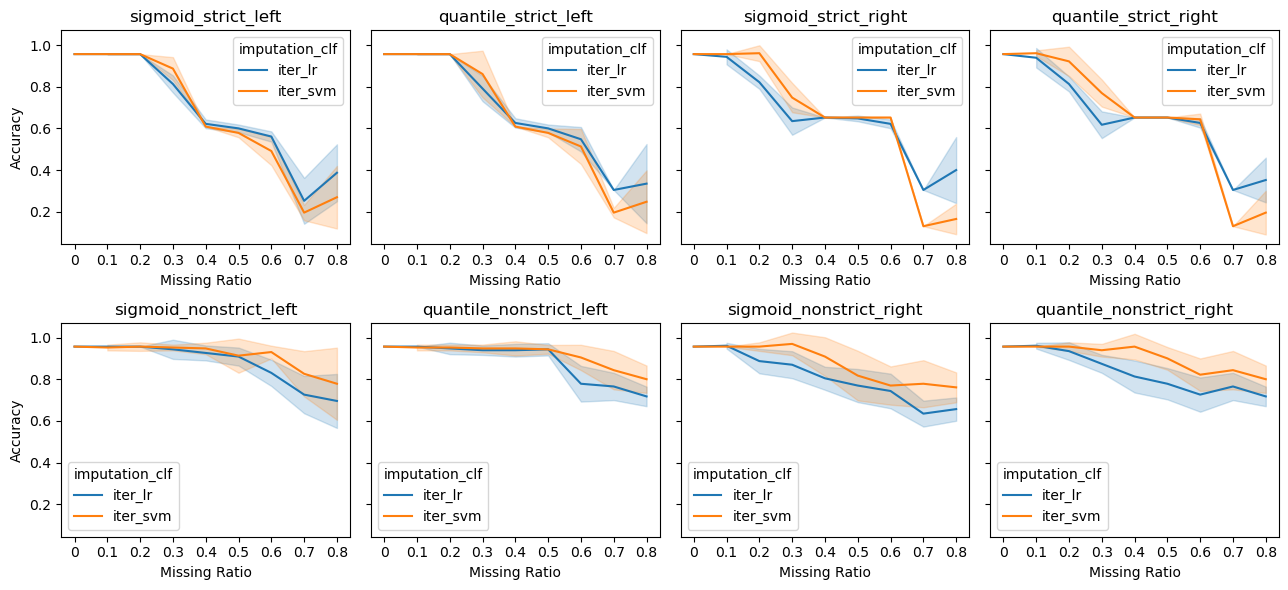

In [23]:
draw_plot_mar('iris', 'mary')

## Telugu

In [14]:
data_name = 'telugu_tabular'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx'][:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['2', '3', '4', '1'], dtype='object')
{'target': '1', 'important_features_idx': [0, 1, 2], 'features_idx': [0, 1, 2], 'num_cols': 3, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(740, 4) (131, 4)
mr 0.1 Simple lr 0.8(0.0117) svm 0.86(0.0123) Iter lr 0.79(0.0179) svm 0.86(0.00867)
mr 0.2 Simple lr 0.75(0.0165) svm 0.85(0.0118) Iter lr 0.75(0.0216) svm 0.86(0.007)
mr 0.3 Simple lr 0.74(0.0234) svm 0.83(0.0113) Iter lr 0.75(0.0217) svm 0.86(0.00992)
mr 0.4 Simple lr 0.74(0.0251) svm 0.82(0.0154) Iter lr 0.74(0.0264) svm 0.85(0.0133)
mr 0.5 Simple lr 0.73(0.031) svm 0.8(0.0185) Iter lr 0.7(0.0424) svm 0.84(0.0188)
mr 0.6 Simple lr 0.71(0.0235) svm 0.77(0.0238) Iter lr 0.66(0.0317) svm 0.81(0.0379)
mr 0.7 Simple lr 0.69(0.033) svm 0.74(0.0324) Iter lr 0.62(0.0315) svm 0.76(0.0522)
mr 0.8 Simple lr 0.67(0.0491) svm 0.74(0.0344) Iter lr 0.61(0.0596) svm 0.67(0.0632)
mr 0.1 Simple lr 0.8(0.00932) svm 0.85(0.00687) Iter lr 0.79(0.0141) svm 0.85(0.0184)

### MCAR

In [44]:
evaluation_mcar(train_data, test_data, config, 'all', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], r_seed = 21, n_rounds = 5, name = 'telugu')

mr 0.1 Simple lr 0.79(0.0106) svm 0.86(0.0126) Iter lr 0.79(0.0111) svm 0.86(0.00953)
mr 0.2 Simple lr 0.78(0.0098) svm 0.84(0.0128) Iter lr 0.77(0.0115) svm 0.86(0.0111)
mr 0.3 Simple lr 0.77(0.0159) svm 0.82(0.00994) Iter lr 0.76(0.0155) svm 0.84(0.0164)
mr 0.4 Simple lr 0.76(0.0164) svm 0.81(0.0101) Iter lr 0.76(0.0223) svm 0.83(0.0198)
mr 0.5 Simple lr 0.74(0.0199) svm 0.8(0.0139) Iter lr 0.75(0.0248) svm 0.81(0.0181)
mr 0.6 Simple lr 0.72(0.0283) svm 0.79(0.0143) Iter lr 0.71(0.0456) svm 0.79(0.028)
mr 0.7 Simple lr 0.71(0.0352) svm 0.77(0.0313) Iter lr 0.67(0.0649) svm 0.74(0.0507)
mr 0.8 Simple lr 0.71(0.0441) svm 0.75(0.0458) Iter lr 0.61(0.0938) svm 0.67(0.0733)


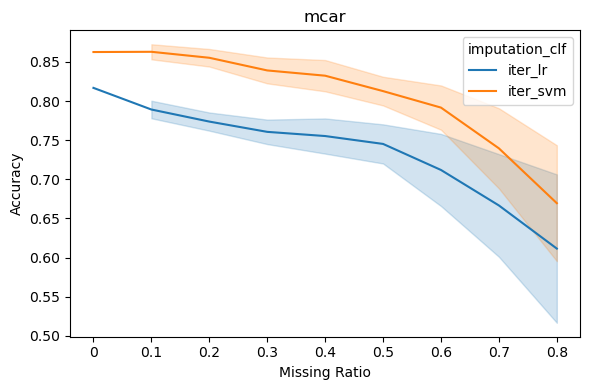

In [305]:
draw_plot_mcar('telugu')

### MAR

In [149]:
cols = [1, 0]
evaluation_mar(train_data, test_data, config, cols, 'sigmoid_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'right',
               r_seed = 21, n_rounds = 5, name = 'telugu')

mr 0.1 Simple lr 0.8(0.00483) svm 0.85(0.00683) Iter lr 0.79(0.0101) svm 0.85(0.00916)
mr 0.2 Simple lr 0.8(0.00611) svm 0.85(0.0101) Iter lr 0.78(0.00611) svm 0.85(0.0104)
mr 0.3 Simple lr 0.8(0.00836) svm 0.84(0.00683) Iter lr 0.78(0.00683) svm 0.83(0.00483)
mr 0.4 Simple lr 0.8(0.00611) svm 0.84(0.00778) Iter lr 0.78(0.017) svm 0.82(0.0114)
mr 0.5 Simple lr 0.78(0.0196) svm 0.83(0.0089) Iter lr 0.78(0.0131) svm 0.82(0.017)
mr 0.6 Simple lr 0.76(0.0189) svm 0.81(0.0142) Iter lr 0.77(0.0203) svm 0.82(0.0177)
mr 0.7 Simple lr 0.75(0.0286) svm 0.79(0.0137) Iter lr 0.77(0.0253) svm 0.77(0.0276)
mr 0.8 Simple lr 0.71(0.0543) svm 0.76(0.0549) Iter lr 0.76(0.0357) svm 0.74(0.0284)


In [140]:
cols = [1, 0]
evaluation_mar(train_data, test_data, config, cols, 'quantile_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'left',
               r_seed = 21, n_rounds = 5, name = 'telugu')

mr 0.1 Simple lr 0.78(0.0142) svm 0.84(0.00374) Iter lr 0.77(0.00305) svm 0.85(0.0104)
mr 0.2 Simple lr 0.76(0.00571) svm 0.83(0.00571) Iter lr 0.74(0.00748) svm 0.82(0.0112)
mr 0.3 Simple lr 0.71(0.0251) svm 0.83(0.00571) Iter lr 0.7(0.0271) svm 0.81(0.0171)
mr 0.4 Simple lr 0.61(0.0201) svm 0.74(0.0465) Iter lr 0.63(0.00571) svm 0.76(0.0544)
mr 0.5 Simple lr 0.5(0.0) svm 0.52(0.00611) Iter lr 0.52(0.023) svm 0.56(0.0218)
mr 0.6 Simple lr 0.65(0.0602) svm 0.79(0.0314) Iter lr 0.59(0.0469) svm 0.66(0.0907)
mr 0.7 Simple lr 0.5(0.00611) svm 0.4(0.0189) Iter lr 0.52(0.0315) svm 0.43(0.0444)
mr 0.8 Simple lr 0.51(0.051) svm 0.67(0.0585) Iter lr 0.47(0.0467) svm 0.39(0.0955)


#### vis

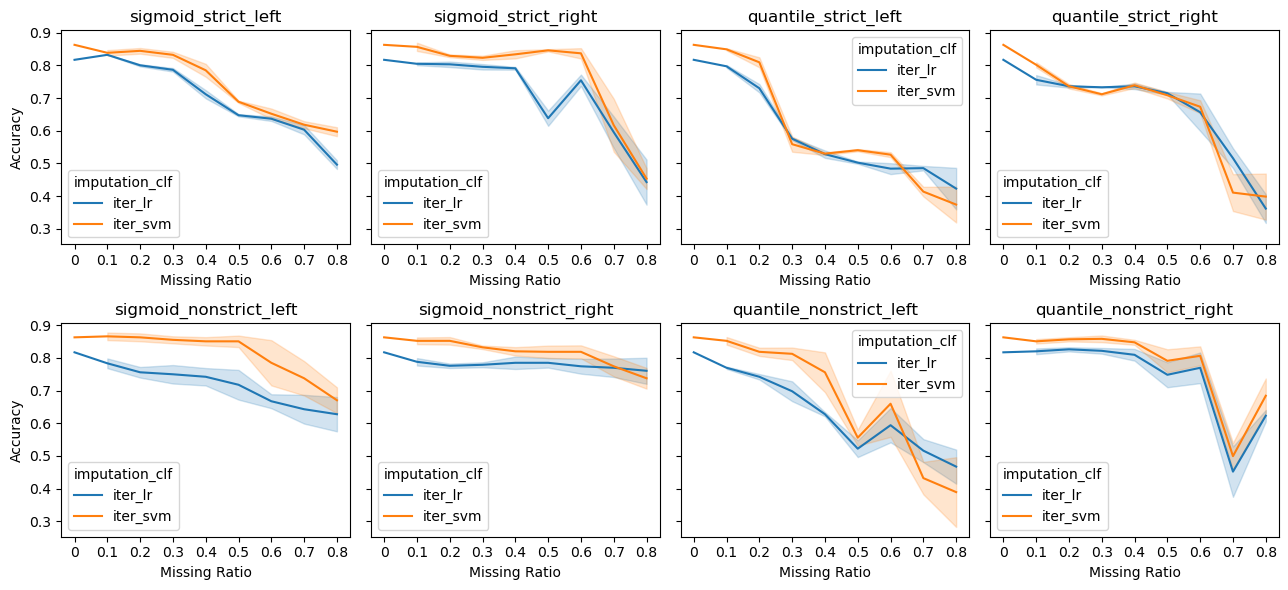

In [286]:
draw_plot_mar('telugu', 'mar')

### MAR Pattern

In [48]:
cols = [0,1,2]
cols_list = []
cols_list.extend(list(itertools.combinations(cols, 2)))
cols_list.extend(list(itertools.combinations(cols, 1)))
ms_patterns = []
for cols in cols_list:
    ms_patterns.append(list(cols))
for ms_pattern in ms_patterns:
    print("pattern: {}".format(ms_pattern))
    evaluation_mar_pattern(train_data, test_data, config, [ms_pattern], 'sigmoid_nonstrict', [0.5], ms_func = 'left',
                   r_seed = 21, n_rounds = 5, name = 'telugu')

pattern: [0, 1]
mr 0.5 Simple lr 0.71(0.0184) svm 0.83(0.0108) Iter lr 0.71(0.00611) svm 0.85(0.0142)
pattern: [0, 2]
mr 0.5 Simple lr 0.77(0.0156) svm 0.82(0.0114) Iter lr 0.71(0.00778) svm 0.84(0.0148)
pattern: [1, 2]
mr 0.5 Simple lr 0.79(0.023) svm 0.83(0.0131) Iter lr 0.79(0.0193) svm 0.83(0.0108)
pattern: [0]
mr 0.5 Simple lr 0.74(0.0183) svm 0.82(0.00966) Iter lr 0.72(0.0196) svm 0.83(0.0243)
pattern: [1]
mr 0.5 Simple lr 0.79(0.0232) svm 0.83(0.0108) Iter lr 0.81(0.0153) svm 0.84(0.00916)
pattern: [2]
mr 0.5 Simple lr 0.81(0.0089) svm 0.85(0.0089) Iter lr 0.82(0.0131) svm 0.85(0.00836)


In [47]:
ms_patterns = [
    [0, 1], [0], [1]
]

print("pattern: {}".format(ms_patterns))
evaluation_mar_pattern(train_data, test_data, config, ms_patterns, 'sigmoid_nonstrict', [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'right',
                r_seed = 21, n_rounds = 5, name = 'telugu')

pattern: [[0, 1], [0], [1]]
mr 0.1 Simple lr 0.8(0.00611) svm 0.84(0.00611) Iter lr 0.78(0.00305) svm 0.85(0.0148)
mr 0.2 Simple lr 0.8(0.00611) svm 0.85(0.00571) Iter lr 0.77(0.00778) svm 0.84(0.00571)
mr 0.3 Simple lr 0.8(0.0089) svm 0.84(0.00305) Iter lr 0.78(0.00374) svm 0.83(0.00483)
mr 0.4 Simple lr 0.77(0.0428) svm 0.82(0.0101) Iter lr 0.76(0.0122) svm 0.82(0.00374)
mr 0.5 Simple lr 0.73(0.0476) svm 0.8(0.0251) Iter lr 0.76(0.0199) svm 0.8(0.0223)
mr 0.6 Simple lr 0.7(0.0378) svm 0.8(0.0303) Iter lr 0.72(0.0157) svm 0.8(0.0156)
mr 0.7 Simple lr 0.7(0.0157) svm 0.81(0.0124) Iter lr 0.72(0.0223) svm 0.77(0.0481)
mr 0.8 Simple lr 0.65(0.0223) svm 0.75(0.0228) Iter lr 0.69(0.0481) svm 0.7(0.0419)


In [51]:
ms_patterns = [
    [0, 1], [0]
]

print("pattern: {}".format(ms_patterns))
evaluation_mar_pattern(train_data, test_data, config, ms_patterns, 'sigmoid_nonstrict', [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8], ms_func = 'left',
                r_seed = 21, n_rounds = 5, name = 'telugu')

pattern: [[0, 1], [0]]
mr 0.1 Simple lr 0.8(0.00966) svm 0.86(0.0089) Iter lr 0.79(0.00374) svm 0.86(0.00571)
mr 0.2 Simple lr 0.77(0.0275) svm 0.84(0.00571) Iter lr 0.74(0.0178) svm 0.86(0.00571)
mr 0.3 Simple lr 0.74(0.0145) svm 0.84(0.00778) Iter lr 0.74(0.0148) svm 0.85(0.0089)
mr 0.4 Simple lr 0.72(0.0239) svm 0.81(0.0104) Iter lr 0.67(0.00778) svm 0.83(0.00374)
mr 0.5 Simple lr 0.73(0.0246) svm 0.78(0.0171) Iter lr 0.64(0.0467) svm 0.83(0.0196)
mr 0.6 Simple lr 0.73(0.0201) svm 0.79(0.0189) Iter lr 0.57(0.0311) svm 0.79(0.0379)
mr 0.7 Simple lr 0.73(0.0273) svm 0.73(0.0291) Iter lr 0.61(0.0333) svm 0.7(0.0606)
mr 0.8 Simple lr 0.63(0.0527) svm 0.71(0.0284) Iter lr 0.59(0.0616) svm 0.67(0.0749)


#### Vis

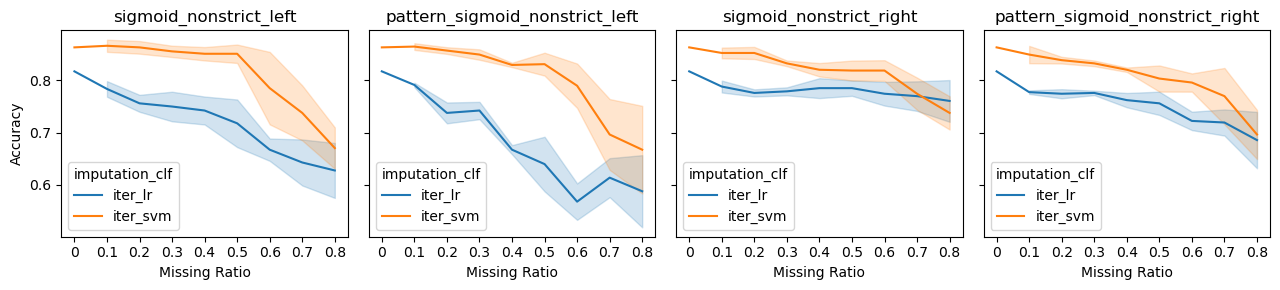

In [52]:
draw_plot_mar_pattern('telugu', 'mar', 'sigmoid_nonstrict')

### MARY

In [167]:
cols = [0, 1, 2]
for option in ['sigmoid_strict', 'sigmoid_nonstrict']:
    for ms_func in ['right', 'left']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds =5, name = 'telugu')

sigmoid_strict right
mr 0.1 Simple lr 0.78(0.0089) svm 0.84(0.0101) Iter lr 0.79(0.00483) svm 0.84(0.00683)
mr 0.2 Simple lr 0.63(0.0) svm 0.69(0.023) Iter lr 0.63(0.00305) svm 0.75(0.0271)
mr 0.3 Simple lr 0.61(0.00305) svm 0.66(0.00611) Iter lr 0.63(0.00305) svm 0.67(0.00916)
mr 0.4 Simple lr 0.62(0.0089) svm 0.63(0.00374) Iter lr 0.61(0.0108) svm 0.57(0.0089)
mr 0.5 Simple lr 0.57(0.00683) svm 0.53(0.00611) Iter lr 0.58(0.00305) svm 0.53(0.0104)
mr 0.6 Simple lr 0.58(0.00305) svm 0.55(0.0193) Iter lr 0.58(0.0157) svm 0.47(0.0769)
mr 0.7 Simple lr 0.36(0.00305) svm 0.36(0.00374) Iter lr 0.41(0.00483) svm 0.39(0.0263)
mr 0.8 Simple lr 0.29(0.0) svm 0.23(0.0404) Iter lr 0.3(0.0) svm 0.33(0.00611)
sigmoid_strict left
mr 0.1 Simple lr 0.83(0.0) svm 0.84(0.00611) Iter lr 0.83(0.0) svm 0.85(0.0)
mr 0.2 Simple lr 0.73(0.0) svm 0.75(0.00305) Iter lr 0.73(0.00374) svm 0.75(0.00305)
mr 0.3 Simple lr 0.71(0.00611) svm 0.72(0.00748) Iter lr 0.71(0.00305) svm 0.69(0.0104)
mr 0.4 Simple lr 0.57(0.

In [168]:
cols = [0, 1, 2]
for option in ['quantile_strict', 'quantile_nonstrict']:
    for ms_func in ['right', 'left']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds =5, name = 'telugu')

quantile_strict right
mr 0.1 Simple lr 0.79(0.0104) svm 0.84(0.00571) Iter lr 0.79(0.00483) svm 0.84(0.0145)
mr 0.2 Simple lr 0.62(0.00305) svm 0.69(0.0137) Iter lr 0.63(0.0) svm 0.72(0.0325)
mr 0.3 Simple lr 0.62(0.00748) svm 0.66(0.0108) Iter lr 0.63(0.00305) svm 0.68(0.00683)
mr 0.4 Simple lr 0.62(0.00571) svm 0.62(0.00483) Iter lr 0.6(0.00966) svm 0.57(0.0101)
mr 0.5 Simple lr 0.57(0.00683) svm 0.53(0.00374) Iter lr 0.58(0.00611) svm 0.54(0.0104)
mr 0.6 Simple lr 0.58(0.0) svm 0.54(0.00374) Iter lr 0.58(0.00571) svm 0.46(0.0761)
mr 0.7 Simple lr 0.36(0.00305) svm 0.37(0.00374) Iter lr 0.4(0.00836) svm 0.41(0.0219)
mr 0.8 Simple lr 0.29(0.0) svm 0.22(0.0541) Iter lr 0.32(0.0089) svm 0.32(0.0148)
quantile_strict left
mr 0.1 Simple lr 0.83(0.0) svm 0.84(0.00611) Iter lr 0.83(0.0) svm 0.85(0.0)
mr 0.2 Simple lr 0.73(0.00305) svm 0.75(0.00305) Iter lr 0.73(0.0) svm 0.75(0.0)
mr 0.3 Simple lr 0.71(0.00748) svm 0.73(0.00966) Iter lr 0.71(0.0104) svm 0.69(0.0089)
mr 0.4 Simple lr 0.56(0.01

#### vis

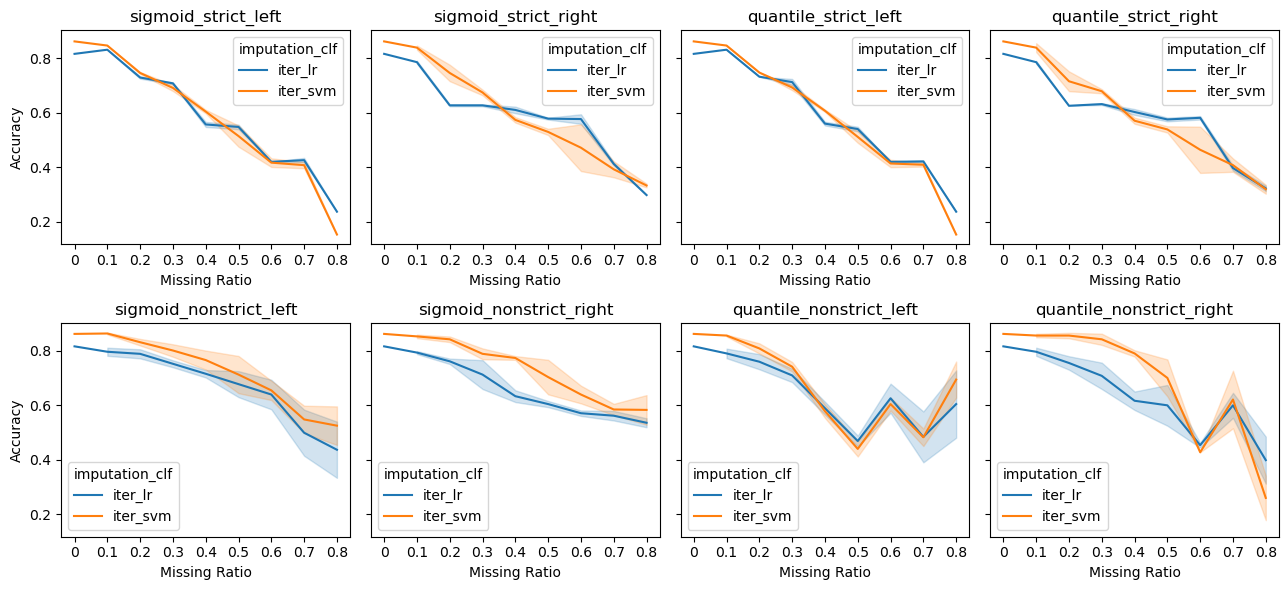

In [287]:
draw_plot_mar('telugu', 'mary')

## Breast Cancer

In [15]:
data_name = 'breast'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst', 'diagnosis'],
      dtype='object')
{'target': 'diagnosis', 'important_features_idx': [1, 3, 13, 7, 12, 14, 0, 2, 4, 15], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'num_cols': 16, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(483, 17) (86, 17)
mr 0.1 Simple lr 0.94(0.00814) svm 0.95(0.0119) Iter lr 0.94(0.00349) svm 0.93(0.0093)
mr 0.2 Simple lr 0.96(0.0119) svm 0.96(0.0114) Iter lr 0.94(0.0052) svm 0.93(0.0119)
mr 0.3 Simple lr 0.97(0.00966) svm 0.96(0.0145) Iter lr 0.94(0.00966) svm 0.95(0.00908)
mr 0.4 Simple lr 0.97(0.00533) svm 0.96(0.0117) Iter lr 0.94(0.0149) svm 0.94(0.00966)
mr 0.5 Simple lr

### MCAR

In [20]:
evaluation_mcar(train_data, test_data, config, 'important', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], r_seed = 21, n_rounds = 10, name = 'breast')

mr 0.5 Simple lr 0.96(0.0145) svm 0.95(0.0138) Iter lr 0.95(0.0121) svm 0.95(0.0174)


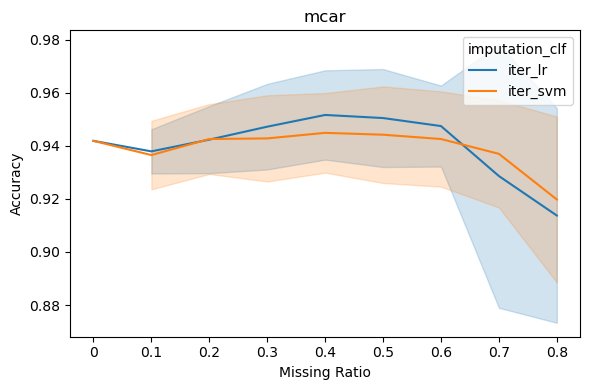

In [306]:
draw_plot_mcar('breast')

### MAR

In [175]:
cols = [1, 3, 13, 7, 12, 14, 0, 2, 4, 15, 9, 11]
for ms_func in ['left', 'right']:
    print(ms_func)
    evaluation_mar(train_data, test_data, config, cols, 'sigmoid_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds = 5, name = 'breast')

left
mr 0.1 Simple lr 0.95(0.0119) svm 0.95(0.0093) Iter lr 0.94(0.0057) svm 0.93(0.0057)
mr 0.2 Simple lr 0.96(0.0158) svm 0.96(0.00465) Iter lr 0.94(0.00465) svm 0.93(0.0119)
mr 0.3 Simple lr 0.96(0.0093) svm 0.96(0.0057) Iter lr 0.94(0.00465) svm 0.94(0.0136)
mr 0.4 Simple lr 0.97(0.0104) svm 0.96(0.0093) Iter lr 0.94(0.0104) svm 0.94(0.0087)
mr 0.5 Simple lr 0.97(1.11e-16) svm 0.96(0.0119) Iter lr 0.95(0.0104) svm 0.94(0.0136)
mr 0.6 Simple lr 0.97(0.00465) svm 0.95(0.00735) Iter lr 0.95(0.0127) svm 0.95(0.0119)
mr 0.7 Simple lr 0.97(0.00735) svm 0.95(0.0136) Iter lr 0.95(0.0164) svm 0.95(0.0225)
mr 0.8 Simple lr 0.96(0.0093) svm 0.95(0.0093) Iter lr 0.93(0.0379) svm 0.93(0.0158)
right
mr 0.1 Simple lr 0.95(0.0154) svm 0.94(0.0171) Iter lr 0.93(0.00735) svm 0.93(0.014)
mr 0.2 Simple lr 0.94(0.0136) svm 0.95(0.0093) Iter lr 0.95(0.0119) svm 0.94(0.0104)
mr 0.3 Simple lr 0.96(0.0057) svm 0.96(0.0087) Iter lr 0.95(0.0158) svm 0.95(0.0136)
mr 0.4 Simple lr 0.95(0.0171) svm 0.96(0.0087)

In [213]:
# quantile
#cols = [1, 3, 13, 7, 12, 14, 0, 2, 4, 15, 9, 11]
# (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15) right sigmoid_strict
# 2, 6, 12, 10, 15, 5, 11, 4 left
# 8, 5 right
# 2, 12, 2, 14, 2, 8 right 2, 9, 2, 4
# 2, 11, 2, 8 left
# right 2, 11, 9, 10, 6, 5, 3
# sigmoid
# left 9
# right 2, 12, 6
cols = [i for i in range(16)]
for item in [2, 6, 12]:
    cols.remove(item)
cols_list = itertools.combinations(cols, 12)
#cols_list = [cols]
#exclude_list = list(itertools.combinations([12, 11, 7, 5], 2))
for cols in cols_list:
    # cols = [i for i in range(16)]
    # cols.remove(2)
    # for item in items:
    #     cols.remove(item)
    print(cols)
    for ms_func in ['right']:
        #print(ms_func)
        evaluation_mar(train_data, test_data, config, cols, 'sigmoid_strict', [0.5], ms_func = ms_func,
                    r_seed = 21, n_rounds = 5, name = 'breast')

(0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14)
mr 0.5 Simple lr 0.91(0.0087) svm 0.92(0.0289) Iter lr 0.89(0.02) svm 0.94(0.0174)
(0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 15)
mr 0.5 Simple lr 0.93(0.0158) svm 0.94(0.00735) Iter lr 0.9(0.0255) svm 0.92(0.02)
(0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15)
mr 0.5 Simple lr 0.92(0.02) svm 0.87(0.0225) Iter lr 0.88(0.0332) svm 0.92(0.0147)
(0, 1, 3, 4, 5, 7, 8, 9, 10, 13, 14, 15)
mr 0.5 Simple lr 0.92(0.014) svm 0.94(0.0158) Iter lr 0.89(0.0309) svm 0.92(0.0348)
(0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 14, 15)
mr 0.5 Simple lr 0.91(0.0309) svm 0.93(0.03) Iter lr 0.9(0.0517) svm 0.92(0.0399)
(0, 1, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15)
mr 0.5 Simple lr 0.92(0.0186) svm 0.9(0.0265) Iter lr 0.91(0.0499) svm 0.91(0.0371)
(0, 1, 3, 4, 5, 7, 9, 10, 11, 13, 14, 15)
mr 0.5 Simple lr 0.95(0.0114) svm 0.94(0.02) Iter lr 0.92(0.0542) svm 0.94(0.03)
(0, 1, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15)
mr 0.5 Simple lr 0.93(0.0114) svm 0.91(0.0309) Iter lr 0.93(0.0119) svm 0.94(0.0136)
(0, 

In [214]:
# 2, 11, 9, 10 right
cols = [i for i in range(16)]
for item in [2, 6, 12]:
    cols.remove(item)
for ms_func in ['right']:
    print(ms_func)
    evaluation_mar(train_data, test_data, config, cols, 'sigmoid_strict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
               r_seed = 21, n_rounds = 5, name = 'breast')

right
mr 0.1 Simple lr 0.95(0.0057) svm 0.95(0.0158) Iter lr 0.93(0.00465) svm 0.93(0.0127)
mr 0.2 Simple lr 0.95(0.0119) svm 0.95(0.0087) Iter lr 0.94(0.0195) svm 0.94(0.0186)
mr 0.3 Simple lr 0.94(0.0186) svm 0.94(0.00735) Iter lr 0.9(0.0237) svm 0.94(0.0208)
mr 0.4 Simple lr 0.93(0.0158) svm 0.94(0.0158) Iter lr 0.89(0.0237) svm 0.91(0.0158)
mr 0.5 Simple lr 0.91(0.0239) svm 0.93(0.0136) Iter lr 0.88(0.0407) svm 0.89(0.0371)
mr 0.6 Simple lr 0.9(0.0239) svm 0.92(0.014) Iter lr 0.9(0.0386) svm 0.9(0.0315)
mr 0.7 Simple lr 0.89(0.0626) svm 0.91(0.0365) Iter lr 0.9(0.053) svm 0.88(0.0154)
mr 0.8 Simple lr 0.86(0.0728) svm 0.88(0.0591) Iter lr 0.9(0.0255) svm 0.82(0.0474)


In [178]:
cols = [1, 3, 13, 7, 12, 14, 0, 2, 4, 5, 6, 9]
for ms_func in ['left', 'right']:
    print(ms_func)
    evaluation_mar(train_data, test_data, config, cols, 'quantile_nonstrict', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
               r_seed = 21, n_rounds = 5, name = 'breast')

left
mr 0.1 Simple lr 0.94(0.0057) svm 0.95(0.0057) Iter lr 0.94(0.00465) svm 0.93(1.11e-16)
mr 0.2 Simple lr 0.97(0.0057) svm 0.97(1.11e-16) Iter lr 0.93(0.00465) svm 0.94(0.014)
mr 0.3 Simple lr 0.97(0.0057) svm 0.94(0.0127) Iter lr 0.94(0.0114) svm 0.93(0.0189)
mr 0.4 Simple lr 0.98(0.0) svm 0.95(0.0203) Iter lr 0.95(0.0093) svm 0.95(0.0093)
mr 0.5 Simple lr 0.97(1.11e-16) svm 0.85(0.0) Iter lr 0.92(1.11e-16) svm 0.87(0.0)
mr 0.6 Simple lr 0.87(0.0) svm 0.6(0.0) Iter lr 0.91(1.11e-16) svm 0.85(0.0)
mr 0.7 Simple lr 0.8(0.0) svm 0.42(0.0) Iter lr 0.82(0.00465) svm 0.8(0.0281)
mr 0.8 Simple lr 0.75(0.0228) svm 0.38(0.0) Iter lr 0.85(0.0127) svm 0.47(0.174)
right
mr 0.1 Simple lr 0.93(0.0087) svm 0.94(0.0119) Iter lr 0.94(0.0216) svm 0.94(0.0087)
mr 0.2 Simple lr 0.92(0.0087) svm 0.93(0.0104) Iter lr 0.95(0.0093) svm 0.95(0.0093)
mr 0.3 Simple lr 0.9(0.00465) svm 0.92(0.0087) Iter lr 0.95(0.0087) svm 0.94(0.0213)
mr 0.4 Simple lr 0.9(0.0087) svm 0.9(0.00735) Iter lr 0.93(0.0093) svm 0.

#### vis

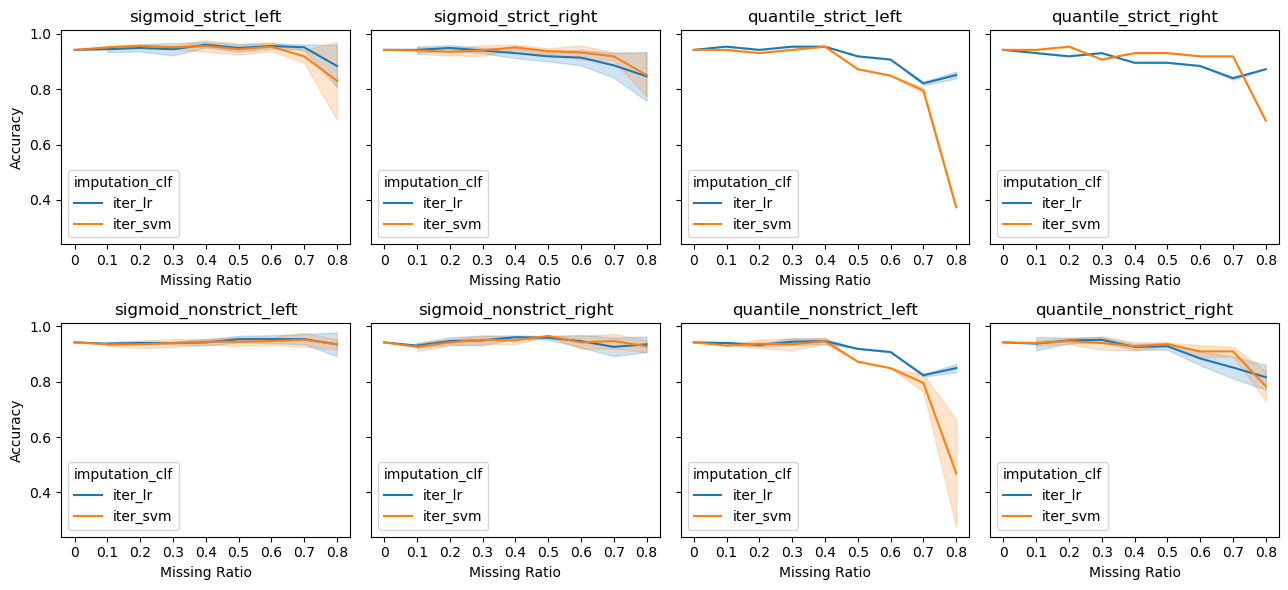

In [288]:
draw_plot_mar('breast', 'mar')

### MARY

In [179]:
cols = config['features_idx']
for option in ['sigmoid_strict', 'sigmoid_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds = 5, name = 'breast')

sigmoid_strict left
mr 0.1 Simple lr 0.95(0.0087) svm 0.95(0.0087) Iter lr 0.94(1.11e-16) svm 0.94(0.0147)
mr 0.2 Simple lr 0.96(0.0057) svm 0.95(0.0114) Iter lr 0.95(0.0087) svm 0.94(0.0087)
mr 0.3 Simple lr 0.94(0.0171) svm 0.95(0.0164) Iter lr 0.95(0.0127) svm 0.95(0.0057)
mr 0.4 Simple lr 0.9(0.0186) svm 0.88(0.048) Iter lr 0.95(0.02) svm 0.94(0.0244)
mr 0.5 Simple lr 0.86(0.00735) svm 0.62(0.0171) Iter lr 0.93(0.0195) svm 0.9(0.0334)
mr 0.6 Simple lr 0.7(0.0195) svm 0.36(0.0174) Iter lr 0.7(0.0174) svm 0.59(0.0547)
mr 0.7 Simple lr 0.63(0.0) svm 0.35(0.0057) Iter lr 0.6(0.0618) svm 0.35(0.0154)
mr 0.8 Simple lr 0.63(0.0) svm 0.36(0.00465) Iter lr 0.63(0.0) svm 0.35(0.0057)
sigmoid_strict right
mr 0.1 Simple lr 0.91(0.0057) svm 0.91(0.0119) Iter lr 0.93(0.00465) svm 0.93(0.0164)
mr 0.2 Simple lr 0.9(0.0093) svm 0.9(0.0154) Iter lr 0.93(0.0171) svm 0.91(0.0174)
mr 0.3 Simple lr 0.86(0.00465) svm 0.83(0.0164) Iter lr 0.9(0.0164) svm 0.9(0.0119)
mr 0.4 Simple lr 0.63(0.0) svm 0.62(0.0

In [180]:
cols = config['features_idx']
for option in ['quantile_strict', 'quantile_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds = 5, name = 'breast')

quantile_strict left
mr 0.1 Simple lr 0.96(0.0119) svm 0.95(0.0136) Iter lr 0.95(0.0093) svm 0.94(0.0114)
mr 0.2 Simple lr 0.96(0.0057) svm 0.96(0.0057) Iter lr 0.95(0.0087) svm 0.94(0.0136)
mr 0.3 Simple lr 0.95(0.00735) svm 0.95(0.0174) Iter lr 0.95(0.0171) svm 0.95(0.00735)
mr 0.4 Simple lr 0.92(0.00465) svm 0.85(0.0147) Iter lr 0.95(0.0158) svm 0.95(0.0119)
mr 0.5 Simple lr 0.86(0.0057) svm 0.6(0.0334) Iter lr 0.91(0.0119) svm 0.9(0.034)
mr 0.6 Simple lr 0.69(0.02) svm 0.35(0.0136) Iter lr 0.72(0.0127) svm 0.61(0.079)
mr 0.7 Simple lr 0.63(0.0) svm 0.35(0.0) Iter lr 0.57(0.0614) svm 0.35(0.00465)
mr 0.8 Simple lr 0.63(0.0) svm 0.36(0.0114) Iter lr 0.64(0.0136) svm 0.36(0.014)
quantile_strict right
mr 0.1 Simple lr 0.92(1.11e-16) svm 0.93(0.0127) Iter lr 0.93(1.11e-16) svm 0.94(0.0119)
mr 0.2 Simple lr 0.9(0.00735) svm 0.92(0.00465) Iter lr 0.92(0.0164) svm 0.92(0.0195)
mr 0.3 Simple lr 0.85(0.00465) svm 0.82(0.0087) Iter lr 0.91(0.0317) svm 0.91(0.0127)
mr 0.4 Simple lr 0.63(0.0) s

#### vis

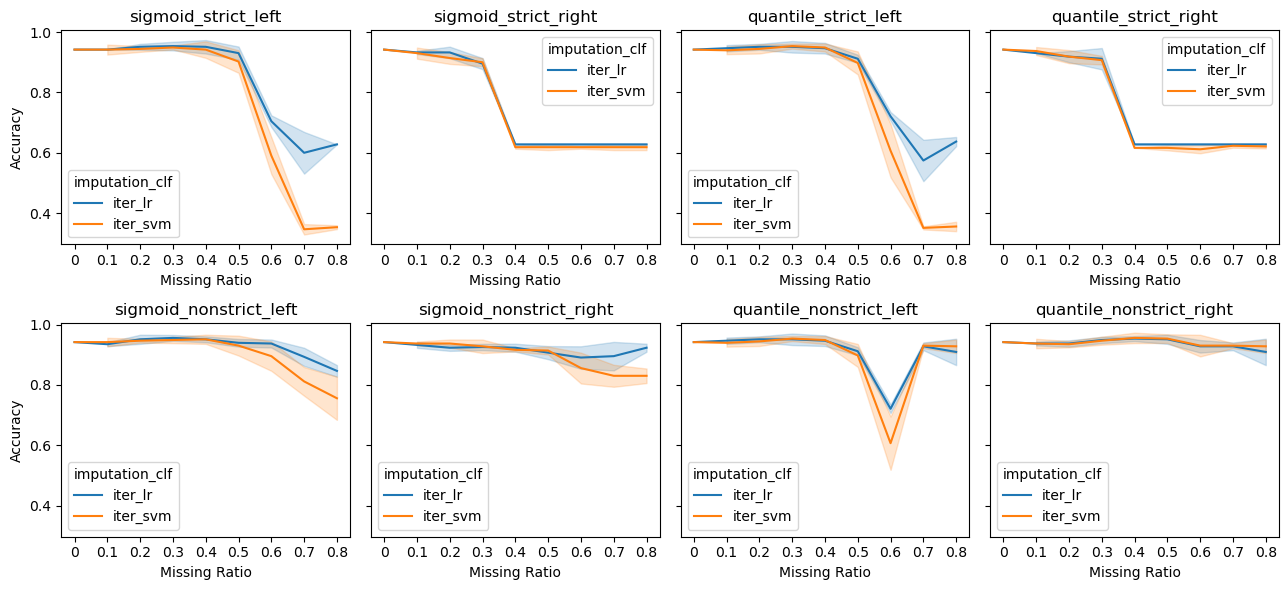

In [289]:
draw_plot_mar('breast', 'mary')

## Ecoli

In [16]:
data_name = 'ecoli'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['1', '2', '3', '4', '5', '6', '7', '8'], dtype='object')
{'target': '8', 'important_features_idx': [5, 6, 1, 0, 4, 2], 'features_idx': [0, 1, 2, 3, 4, 5, 6], 'num_cols': 7, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(285, 8) (51, 8)
mr 0.1 Simple lr 0.96(0.00877) svm 0.96(0.00588) Iter lr 0.96(1.11e-16) svm 0.95(0.013)
mr 0.2 Simple lr 0.96(0.00877) svm 0.96(0.00784) Iter lr 0.95(0.0132) svm 0.96(0.00784)
mr 0.3 Simple lr 0.95(0.0251) svm 0.96(1.11e-16) Iter lr 0.92(0.0223) svm 0.95(0.0192)
mr 0.4 Simple lr 0.95(0.0216) svm 0.95(0.013) Iter lr 0.91(0.0306) svm 0.93(0.0319)
mr 0.5 Simple lr 0.95(0.0251) svm 0.95(0.0153) Iter lr 0.87(0.0882) svm 0.91(0.0364)
mr 0.6 Simple lr 0.95(0.0176) svm 0.94(0.0171) Iter lr 0.9(0.0489) svm 0.91(0.0291)
mr 0.7 Simple lr 0.93(0.0431) svm 0.94(0.0163) Iter lr 0.9(0.0421) svm 0.91(0.0549)
mr 0.8 Simple lr 0.92(0.0291) svm 0.93(0.0319) Iter lr 0.84(0.0539) svm 0.88(0.0551)
mr 0.1 Simple lr 0.96(0.0106) svm 0.

### MCAR

In [48]:
evaluation_mcar(train_data, test_data, config, 'all', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], r_seed = 21, n_rounds = 50, name = 'ecoli')

mr 0.1 Simple lr 0.96(0.0106) svm 0.96(0.00768) Iter lr 0.96(0.0111) svm 0.96(0.00785)
mr 0.2 Simple lr 0.96(0.0188) svm 0.95(0.012) Iter lr 0.95(0.0161) svm 0.95(0.0113)
mr 0.3 Simple lr 0.95(0.0177) svm 0.95(0.0142) Iter lr 0.94(0.0231) svm 0.95(0.0167)
mr 0.4 Simple lr 0.95(0.0228) svm 0.95(0.014) Iter lr 0.92(0.0493) svm 0.93(0.0266)
mr 0.5 Simple lr 0.95(0.0255) svm 0.95(0.0165) Iter lr 0.9(0.047) svm 0.92(0.0308)
mr 0.6 Simple lr 0.94(0.0265) svm 0.94(0.0191) Iter lr 0.89(0.0887) svm 0.91(0.0275)
mr 0.7 Simple lr 0.93(0.0273) svm 0.93(0.0288) Iter lr 0.88(0.0488) svm 0.88(0.0432)
mr 0.8 Simple lr 0.93(0.0296) svm 0.92(0.0382) Iter lr 0.85(0.065) svm 0.86(0.054)


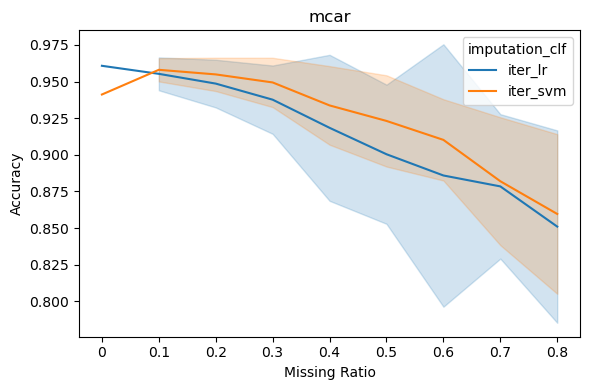

In [308]:
draw_plot_mcar('ecoli')

### MAR

In [296]:
cols = [5, 6, 0, 4, 2, 3]
for option in ['sigmoid_strict', 'sigmoid_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mar(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
               r_seed = 21, n_rounds = 10, name = 'ecoli')

sigmoid_strict left
mr 0.1 Simple lr 0.96(1.11e-16) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.96(0.00588)
mr 0.2 Simple lr 0.96(0.00784) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.96(1.11e-16)
mr 0.3 Simple lr 0.96(1.11e-16) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.95(0.00961)
mr 0.4 Simple lr 0.96(1.11e-16) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.92(0.0)
mr 0.5 Simple lr 0.96(0.0118) svm 0.95(0.00899) Iter lr 0.93(0.013) svm 0.88(0.0106)
mr 0.6 Simple lr 0.93(0.0157) svm 0.95(0.0233) Iter lr 0.91(0.0171) svm 0.88(0.0152)
mr 0.7 Simple lr 0.91(0.0233) svm 0.92(0.034) Iter lr 0.85(0.0235) svm 0.87(0.018)
mr 0.8 Simple lr 0.61(0.104) svm 0.75(0.0176) Iter lr 0.64(0.0661) svm 0.69(0.034)
sigmoid_strict right
mr 0.1 Simple lr 0.96(1.11e-16) svm 0.96(0.00877) Iter lr 0.94(0.0) svm 0.96(0.00588)
mr 0.2 Simple lr 0.93(0.00784) svm 0.94(0.00784) Iter lr 0.93(0.0118) svm 0.95(0.013)
mr 0.3 Simple lr 0.87(0.0153) svm 0.89(0.0266) Iter lr 0.81(0.0176) svm 0.9(0.0377)
mr 

In [299]:
cols = [5, 6, 0, 4, 2, 3]
for option in ['quantile_strict', 'quantile_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mar(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
               r_seed = 21, n_rounds = 10, name = 'ecoli')

quantile_strict left
mr 0.1 Simple lr 0.96(1.11e-16) svm 0.96(1.11e-16) Iter lr 0.96(1.11e-16) svm 0.96(1.11e-16)
mr 0.2 Simple lr 0.96(0.0137) svm 0.95(0.013) Iter lr 0.96(1.11e-16) svm 0.95(0.0157)
mr 0.3 Simple lr 0.98(1.11e-16) svm 0.94(0.0) Iter lr 0.96(1.11e-16) svm 0.9(0.0)
mr 0.4 Simple lr 0.95(0.0176) svm 0.94(0.0171) Iter lr 0.91(0.00784) svm 0.89(0.018)
mr 0.5 Simple lr 0.9(0.00588) svm 0.92(0.0264) Iter lr 0.84(0.0137) svm 0.9(0.0152)
mr 0.6 Simple lr 0.89(0.0353) svm 0.87(0.0421) Iter lr 0.79(0.0294) svm 0.89(0.0216)
mr 0.7 Simple lr 0.84(0.034) svm 0.81(0.0686) Iter lr 0.69(0.0994) svm 0.63(0.0507)
mr 0.8 Simple lr 0.54(0.23) svm 0.68(0.0686) Iter lr 0.31(5.55e-17) svm 0.34(0.00899)
quantile_strict right
mr 0.1 Simple lr 0.93(0.00784) svm 0.92(0.0106) Iter lr 0.95(0.00784) svm 0.93(0.0192)
mr 0.2 Simple lr 0.86(0.00899) svm 0.96(1.11e-16) Iter lr 0.88(1.11e-16) svm 0.94(0.0118)
mr 0.3 Simple lr 0.82(0.00784) svm 0.9(0.0163) Iter lr 0.84(0.0106) svm 0.87(0.0291)
mr 0.4 Sim

In [54]:
cols = [5, 6, 1, 0, 4, 2, 3]
col_lists = list(itertools.combinations(cols, 6))
for cols in col_lists:
    cols = list(cols)
    print(cols)
    evaluation_mar(train_data, test_data, config, cols, 'quantile_nonstrict', [0.5], ms_func = 'right',
               r_seed = 21, n_rounds = 10, name = 'ecoli')

[5, 6, 1, 0, 4, 2]
mr 0.5 Simple lr 0.95(0.0153) svm 0.92(0.0205) Iter lr 0.94(0.0185) svm 0.84(0.0685)
[5, 6, 1, 0, 4, 3]
mr 0.5 Simple lr 0.93(0.0147) svm 0.92(0.0152) Iter lr 0.91(0.0384) svm 0.9(0.0575)
[5, 6, 1, 0, 2, 3]
mr 0.5 Simple lr 0.93(0.0181) svm 0.92(0.0205) Iter lr 0.94(0.0137) svm 0.88(0.0539)
[5, 6, 1, 4, 2, 3]
mr 0.5 Simple lr 0.95(0.00961) svm 0.94(0.0106) Iter lr 0.92(0.0205) svm 0.95(0.013)
[5, 6, 0, 4, 2, 3]
mr 0.5 Simple lr 0.92(0.0175) svm 0.93(0.0266) Iter lr 0.86(0.0126) svm 0.89(0.028)
[5, 1, 0, 4, 2, 3]
mr 0.5 Simple lr 0.92(0.00899) svm 0.89(0.018) Iter lr 0.93(0.0192) svm 0.87(0.0342)
[6, 1, 0, 4, 2, 3]
mr 0.5 Simple lr 0.93(0.0098) svm 0.94(0.00899) Iter lr 0.94(0.0137) svm 0.92(0.0239)


#### vis

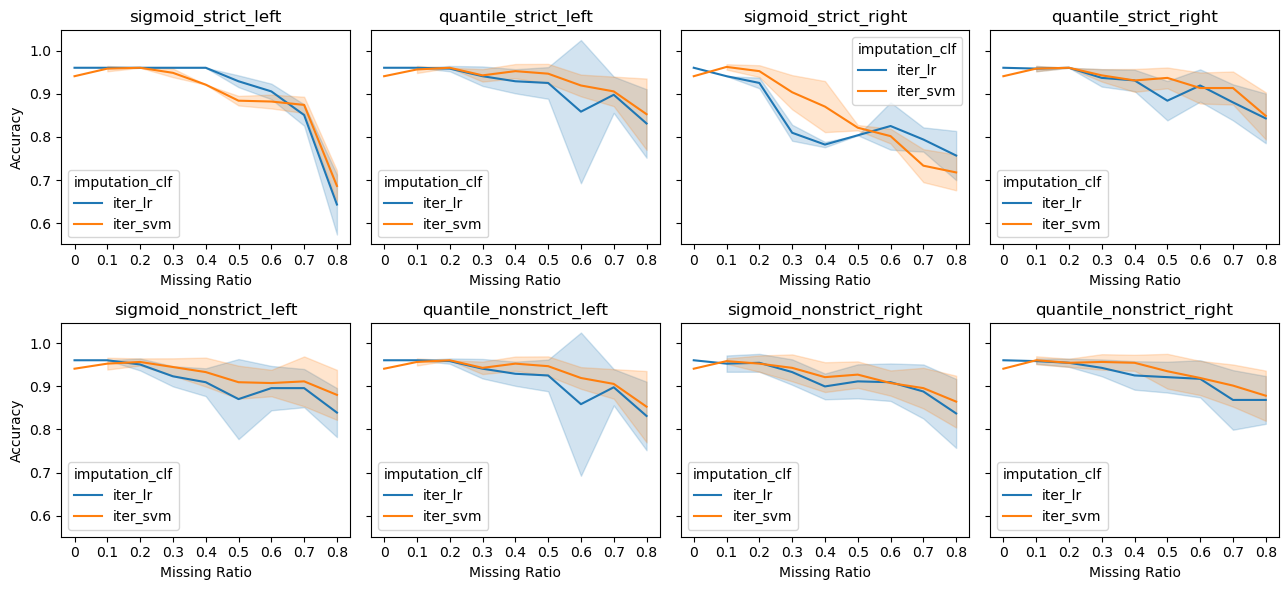

In [18]:
draw_plot_mar('ecoli', 'mar')

### MARY

In [223]:
cols = config['features_idx']
for option in ['sigmoid_strict', 'sigmoid_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds = 10, name = 'ecoli')

sigmoid_strict left
mr 0.1 Simple lr 0.97(0.00961) svm 0.94(0.0) Iter lr 0.96(1.11e-16) svm 0.94(0.0)
mr 0.2 Simple lr 0.96(0.00877) svm 0.94(0.00588) Iter lr 0.96(0.00784) svm 0.94(0.0)
mr 0.3 Simple lr 0.92(0.0106) svm 0.93(0.0158) Iter lr 0.91(0.0181) svm 0.87(0.0229)
mr 0.4 Simple lr 0.81(0.0245) svm 0.61(0.0304) Iter lr 0.79(0.0474) svm 0.53(0.0345)
mr 0.5 Simple lr 0.58(0.0266) svm 0.53(0.0163) Iter lr 0.58(0.0319) svm 0.53(0.0124)
mr 0.6 Simple lr 0.54(0.0197) svm 0.51(0.0171) Iter lr 0.56(0.0422) svm 0.5(0.0201)
mr 0.7 Simple lr 0.54(0.0235) svm 0.49(0.0326) Iter lr 0.56(0.026) svm 0.44(0.0519)
mr 0.8 Simple lr 0.22(0.0211) svm 0.21(0.0223) Iter lr 0.21(0.0185) svm 0.23(0.018)
sigmoid_strict right
mr 0.1 Simple lr 0.9(0.00588) svm 0.88(0.00588) Iter lr 0.9(0.0) svm 0.88(1.11e-16)
mr 0.2 Simple lr 0.87(0.0126) svm 0.84(0.0185) Iter lr 0.89(0.0147) svm 0.83(0.0304)
mr 0.3 Simple lr 0.75(0.0132) svm 0.74(0.00899) Iter lr 0.76(0.00784) svm 0.75(0.0124)
mr 0.4 Simple lr 0.74(0.0163)

In [224]:
cols = config['features_idx']
for option in ['quantile_strict', 'quantile_nonstrict']:
    for ms_func in ['left', 'right']:
        print(option, ms_func)
        evaluation_mary(train_data, test_data, config, cols, option, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ms_func = ms_func,
                r_seed = 21, n_rounds = 10, name = 'ecoli')

quantile_strict left
mr 0.1 Simple lr 0.98(0.00784) svm 0.94(0.0) Iter lr 0.96(1.11e-16) svm 0.94(0.0)
mr 0.2 Simple lr 0.96(0.0118) svm 0.94(0.0106) Iter lr 0.97(0.00899) svm 0.94(0.00588)
mr 0.3 Simple lr 0.92(0.00899) svm 0.93(0.026) Iter lr 0.91(0.0132) svm 0.85(0.0293)
mr 0.4 Simple lr 0.81(0.0283) svm 0.61(0.0283) Iter lr 0.8(0.0459) svm 0.53(0.0223)
mr 0.5 Simple lr 0.58(0.0266) svm 0.53(0.0211) Iter lr 0.61(0.0421) svm 0.53(0.0147)
mr 0.6 Simple lr 0.58(0.0319) svm 0.51(0.0223) Iter lr 0.59(0.0515) svm 0.51(0.0211)
mr 0.7 Simple lr 0.56(0.0157) svm 0.51(0.0316) Iter lr 0.55(0.0789) svm 0.44(0.0675)
mr 0.8 Simple lr 0.21(0.0106) svm 0.21(0.00899) Iter lr 0.21(0.0176) svm 0.21(0.00784)
quantile_strict right
mr 0.1 Simple lr 0.9(0.0) svm 0.88(1.11e-16) Iter lr 0.9(0.0) svm 0.88(1.11e-16)
mr 0.2 Simple lr 0.87(0.018) svm 0.84(0.0157) Iter lr 0.89(0.00961) svm 0.84(0.0232)
mr 0.3 Simple lr 0.75(0.013) svm 0.73(0.0153) Iter lr 0.76(0.00588) svm 0.73(0.0239)
mr 0.4 Simple lr 0.75(0.0)

#### vis

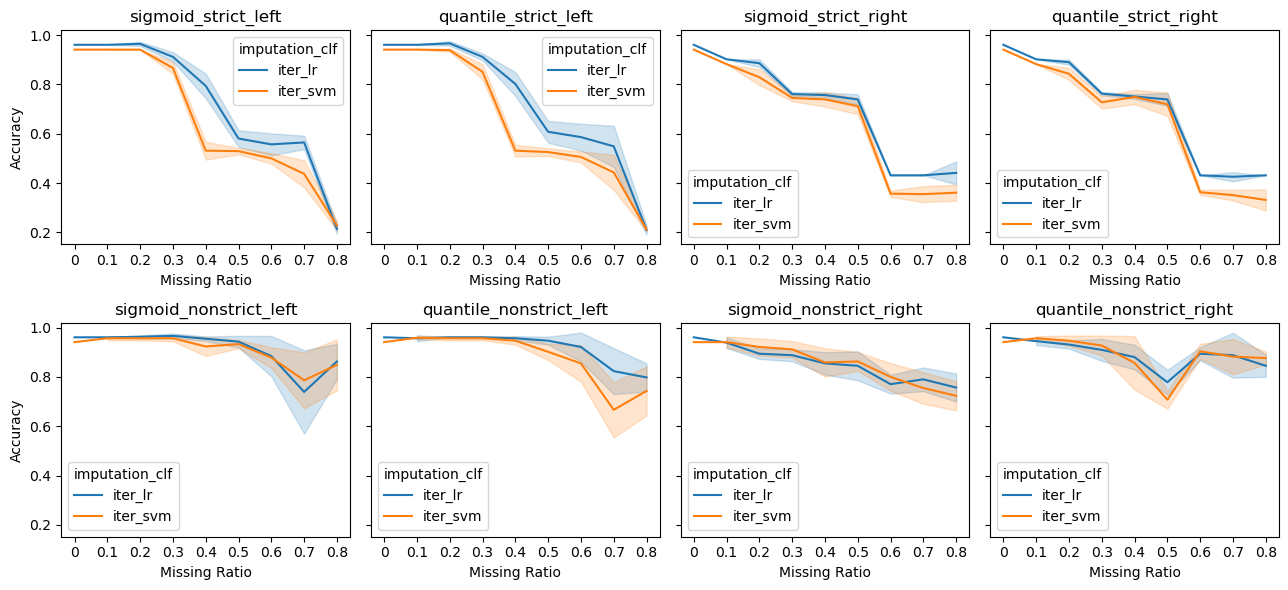

In [19]:
draw_plot_mar('ecoli', 'mary')

In [49]:
data, config = load_data('wine_quality_all')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

1    3915
0    2384
2     198
Name: quality, dtype: int64
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type', 'quality'],
      dtype='object')
{'target': 'quality', 'important_features_idx': [10, 7, 1, 4, 11], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 12, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(5522, 13) (975, 13)


quality                 1.000000
alcohol                 0.414366
density                 0.285245
volatile acidity        0.267544
chlorides               0.189512
type                    0.126314
fixed acidity           0.078980
citric acid             0.076211
free sulfur dioxide     0.056267
total sulfur dioxide    0.049069
sulphates               0.045999
residual sugar          0.032498
pH                      0.019510
dtype: float64

In [219]:
evaluation_mcar(train_data, test_data, config, 'all', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], r_seed = 21, n_rounds = 5, name = 'wine_quality')

mr 0.1 Simple lr 0.94(0.0147) svm 0.95(0.0158) Iter lr 0.94(0.0057) svm 0.93(0.00735)
mr 0.2 Simple lr 0.95(0.0195) svm 0.94(0.0136) Iter lr 0.93(0.0154) svm 0.94(0.0104)
mr 0.3 Simple lr 0.96(0.0154) svm 0.95(0.0127) Iter lr 0.96(0.0093) svm 0.94(0.0265)
mr 0.4 Simple lr 0.96(0.0093) svm 0.95(0.0171) Iter lr 0.96(0.0154) svm 0.94(0.0195)
mr 0.5 Simple lr 0.95(0.0093) svm 0.95(0.0174) Iter lr 0.94(0.0189) svm 0.93(0.0225)
mr 0.6 Simple lr 0.96(0.0171) svm 0.95(0.0119) Iter lr 0.95(0.0147) svm 0.95(0.0136)
mr 0.7 Simple lr 0.95(0.0119) svm 0.95(0.0119) Iter lr 0.87(0.118) svm 0.93(0.0329)
mr 0.8 Simple lr 0.94(0.0186) svm 0.94(0.0127) Iter lr 0.91(0.0271) svm 0.93(0.0265)


## others

In [20]:
data_name = 'wine'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
       '1'],
      dtype='object')
{'target': '1', 'important_features_idx': [6, 12, 11, 0, 9, 10, 5, 1, 3, 8, 7, 2, 4], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 13, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(151, 14) (27, 14)
mr 0.1 Simple lr 0.96(0.0308) svm 0.96(0.0199) Iter lr 0.96(1.11e-16) svm 0.95(0.017)
mr 0.2 Simple lr 0.95(0.017) svm 0.96(0.0148) Iter lr 0.97(0.0199) svm 0.96(0.0111)
mr 0.3 Simple lr 0.96(0.0199) svm 0.96(0.0111) Iter lr 0.94(0.038) svm 0.95(0.0237)
mr 0.4 Simple lr 0.97(0.0199) svm 0.96(0.0166) Iter lr 0.93(0.0323) svm 0.94(0.0248)
mr 0.5 Simple lr 0.96(0.0111) svm 0.96(0.0111) Iter lr 0.95(0.0181) svm 0.94(0.0246)
mr 0.6 Simple lr 0.96(1.11e-16) svm 0.94(0.0289) Iter lr 0.91(0.0625) svm 0.93(0.0308)
mr 0.7 Simple lr 0.95(0.0181) svm 0.93(0.0509) Iter lr 0.94(0.0333) svm 0.92(0.0452)
mr 0.8 Simple lr 0.94(0.0339)

In [21]:
data_name = 'spam'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

['21', '23', '7', '53', '19', '16', '17', '25', '57', '5', '52', '11', '26', '6', '9', '24', '56', '8', '18', '3', '15', '20', '27', '37', '30', '28', '35', '46', '45', '10', '42', '36', '43', '29', '13', '31', '1', '39', '33', '32', '34', '55']
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58'],
      dtype='object')
{'target': '58', 'important_features_idx': [20, 22, 6, 52, 18, 15, 16, 24, 56, 4, 51, 10, 25, 5, 8, 23, 55, 7, 17, 2, 14, 19, 26, 36, 29, 27, 34, 45, 44, 9, 41, 35, 42, 28, 12, 30, 0, 38, 32, 31, 33, 54], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3

KeyboardInterrupt: 

In [22]:
data_name = 'pima_diabetes'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
{'target': 'Outcome', 'important_features_idx': [1, 5, 7, 0, 6, 4], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(652, 9) (116, 9)
mr 0.1 Simple lr 0.74(0.00668) svm 0.73(0.0132) Iter lr 0.76(0.00866) svm 0.75(0.0201)
mr 0.2 Simple lr 0.75(0.00795) svm 0.73(0.0108) Iter lr 0.78(0.00668) svm 0.76(0.0218)
mr 0.3 Simple lr 0.74(0.00716) svm 0.72(0.0119) Iter lr 0.78(0.00948) svm 0.74(0.022)
mr 0.4 Simple lr 0.74(0.0096) svm 0.71(0.0134) Iter lr 0.77(0.0114) svm 0.73(0.0152)
mr 0.5 Simple lr 0.73(0.0139) svm 0.71(0.0123) Iter lr 0.77(0.0181) svm 0.74(0.0256)
mr 0.6 Simple lr 0.72(0.0136) svm 0.72(0.0167) Iter lr 0.74(0.045) svm 0.73(0.0325)
mr 0.7 Simple lr 0.73(0.0109) svm 0.72(0.00845) Iter lr 0.7(0.0555) svm 0.71(0.0509)
mr 0.8 Simple 

In [23]:
data_name = 'yeast'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
{'target': '9', 'important_features_idx': [2, 5, 0, 1, 3], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(1257, 9) (222, 9)
mr 0.1 Simple lr 0.62(0.00949) svm 0.63(0.0101) Iter lr 0.62(0.00674) svm 0.63(0.0109)
mr 0.2 Simple lr 0.62(0.0067) svm 0.63(0.00933) Iter lr 0.62(0.00888) svm 0.63(0.0112)
mr 0.3 Simple lr 0.62(0.00832) svm 0.62(0.0101) Iter lr 0.62(0.00525) svm 0.63(0.0119)
mr 0.4 Simple lr 0.61(0.00676) svm 0.61(0.0121) Iter lr 0.62(0.00983) svm 0.63(0.011)
mr 0.5 Simple lr 0.62(0.0101) svm 0.62(0.0148) Iter lr 0.6(0.00902) svm 0.61(0.0187)
mr 0.6 Simple lr 0.62(0.00721) svm 0.61(0.0157) Iter lr 0.59(0.0305) svm 0.58(0.0403)
mr 0.7 Simple lr 0.62(0.00883) svm 0.61(0.0095) Iter lr 0.58(0.0233) svm 0.56(0.0323)
mr 0.8 Simple lr 0.61(0.00865) svm 0.61(0.0177) Iter lr 0.54(0.0594) svm 0.52(0.0395)
mr 0.1 Simple lr 0.62(0.

In [24]:
data_name = 'dermatology'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35'],
      dtype='object')
{'target': '35', 'important_features_idx': [32, 26, 28, 30, 5, 11, 24, 14, 19, 7, 21, 20, 29, 6, 8, 15, 27, 9, 23, 13, 2, 25, 4, 22, 3, 18, 1], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'num_cols': 34, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(304, 35) (54, 35)
mr 0.1 Simple lr 0.97(0.00741) svm 0.96(0.0117) Iter lr 0.97(0.00849) svm 0.96(0.00997)
mr 0.2 Simple lr 0.97(0.00907) svm 0.96(0.00997) Iter lr 0.97(0.0111) svm 0.96(0.00997)
mr 0.3 Simple lr 0.98(0.00741) svm 0.97(0.0139) Iter lr 0.95(0.0206) svm 0.96(0.0117)
mr 0.4 Simple lr 0.96(0.0154) svm 0.96(0.013) Iter lr 0.96(0.0185) svm 0.96(0.0139)
mr 0

In [25]:
data_name = 'sonar'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'],
      dtype='object')
{'target': '61', 'important_features_idx': [10, 11, 48, 9, 44, 47, 8, 12, 45, 46, 50, 51, 43, 0, 35, 3, 20, 42, 1, 34, 19, 4, 36, 21, 2, 7, 57, 53, 49, 33, 13], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'num_cols': 60, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(176, 61) (32, 61)
mr 0.1 Simple lr 0.76(0.0187) svm 0.83(0.0143) Iter lr 0.7

In [26]:
data_name = 'glass'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')
{'target': '10', 'important_features_idx': [2, 3, 7, 1, 5, 6, 8, 4, 0], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'num_cols': 9, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(174, 10) (31, 10)
mr 0.1 Simple lr 0.53(0.0258) svm 0.67(0.029) Iter lr 0.55(0.025) svm 0.65(0.029)
mr 0.2 Simple lr 0.52(0.0204) svm 0.65(0.054) Iter lr 0.56(0.0324) svm 0.65(0.0281)
mr 0.3 Simple lr 0.52(0.0433) svm 0.65(0.0466) Iter lr 0.56(0.0648) svm 0.65(0.0355)
mr 0.4 Simple lr 0.5(0.0329) svm 0.62(0.0521) Iter lr 0.55(0.0488) svm 0.68(0.0603)
mr 0.5 Simple lr 0.52(0.0403) svm 0.61(0.0443) Iter lr 0.52(0.0403) svm 0.65(0.029)
mr 0.6 Simple lr 0.52(0.0443) svm 0.6(0.0413) Iter lr 0.47(0.0949) svm 0.63(0.0696)
mr 0.7 Simple lr 0.51(0.0316) svm 0.56(0.0524) Iter lr 0.54(0.0764) svm 0.58(0.0529)
mr 0.8 Simple lr 0.51(0.0434) svm 0.51(0.0684) Iter lr 0.49(0.0536) svm 0.56(0.0817)
mr 0.1 Simple lr 0.

In [27]:
data_name = 'red'
data, config = load_data(data_name)
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
cols_mar = config['important_features_idx']
if len(cols_mar) == train_data.shape[1] - 1:
    cols_mar = cols_mar[:-1]
cols_mary = config['features_idx']
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eval_all(train_data, test_data, config, cols_mar, cols_mary, missing_ratios, r_seed = 21, n_rounds = 10, name = data_name)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
{'target': 'quality', 'important_features_idx': [10, 1, 6, 9, 2, 7], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'num_cols': 11, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(1359, 12) (240, 12)
mr 0.1 Simple lr 0.57(0.0104) svm 0.59(0.0153) Iter lr 0.57(0.0111) svm 0.61(0.0147)
mr 0.2 Simple lr 0.56(0.0112) svm 0.59(0.0153) Iter lr 0.57(0.00816) svm 0.6(0.0149)
mr 0.3 Simple lr 0.55(0.00958) svm 0.58(0.00951) Iter lr 0.56(0.00839) svm 0.59(0.0177)
mr 0.4 Simple lr 0.55(0.00726) svm 0.57(0.0115) Iter lr 0.56(0.0104) svm 0.58(0.0181)
mr 0.5 Simple lr 0.56(0.0102) svm 0.57(0.00902) Iter lr 0.56(0.0112) svm 0.57(0.015)
mr 0.6 Simple lr 0.55(0.0124) svm 0.56(0.00837) Iter lr 0.55(0.026) svm 0.57(0.00909)
mr 0.7 Simple lr 0

## Visualization

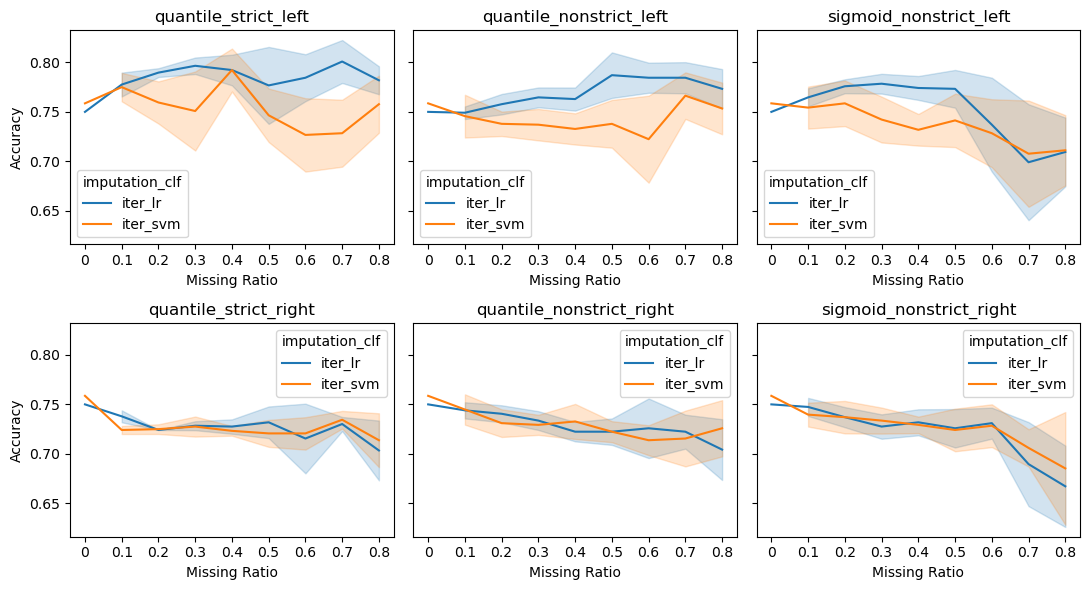

In [40]:
draw_plot_mar('pima_diabetes', 'mar')

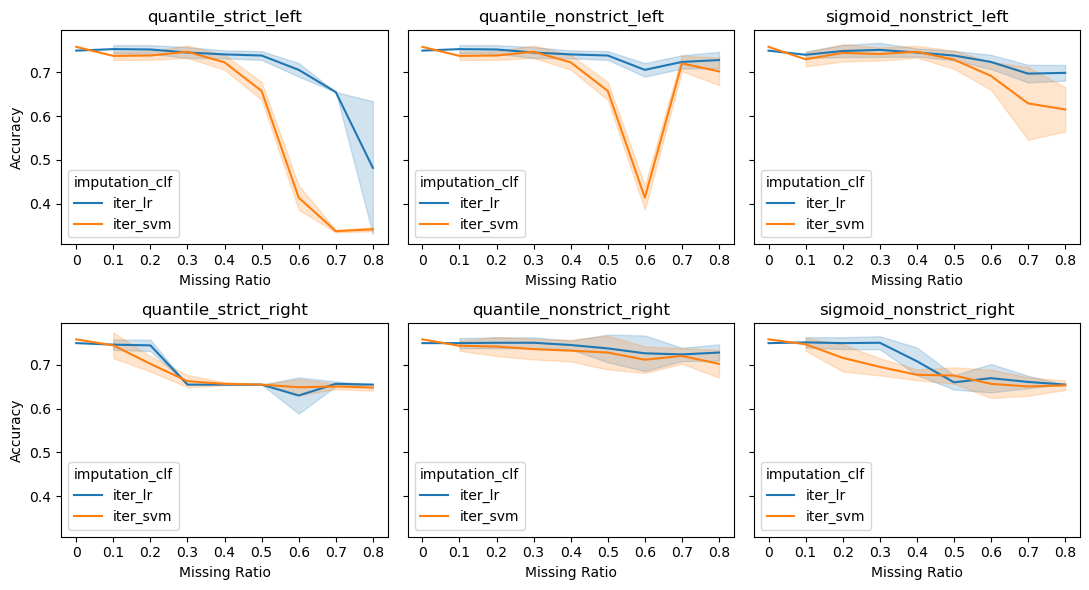

In [41]:
draw_plot_mar('pima_diabetes', 'mary')

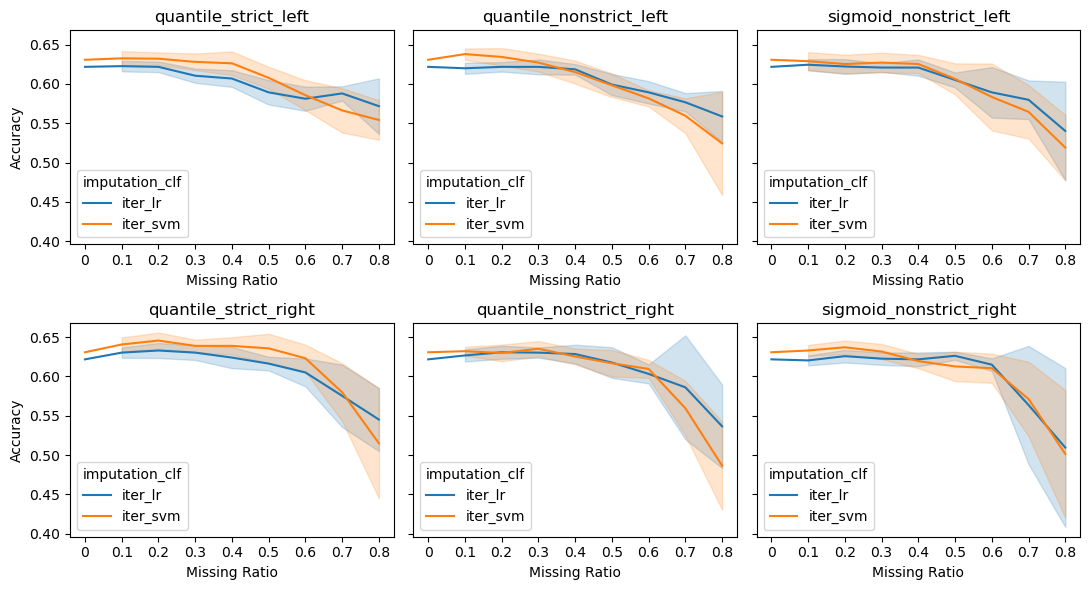

In [42]:
draw_plot_mar('yeast', 'mar')

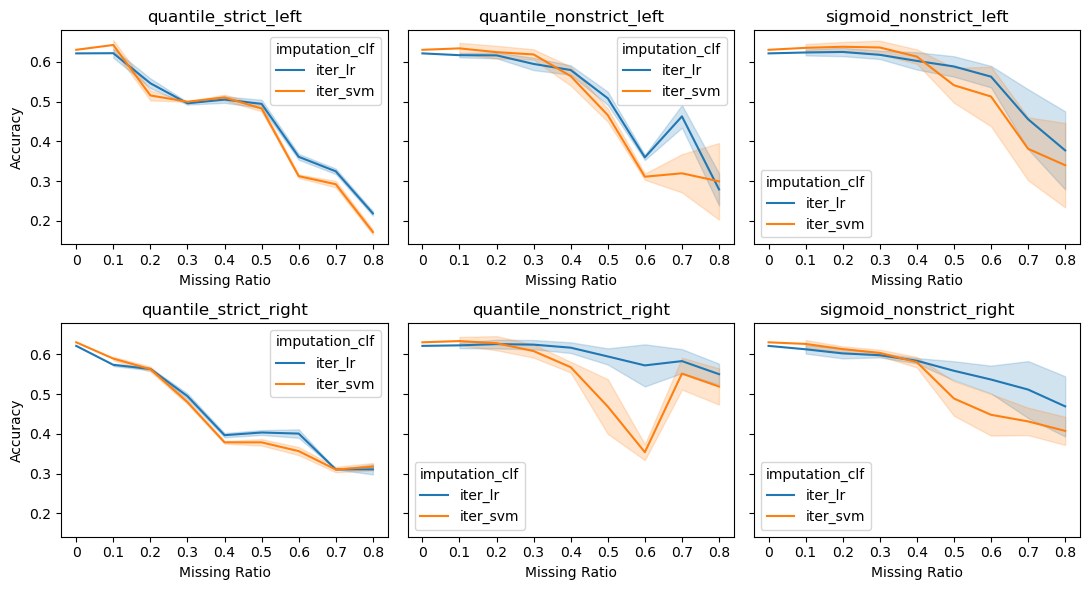

In [43]:
draw_plot_mar('yeast', 'mary')

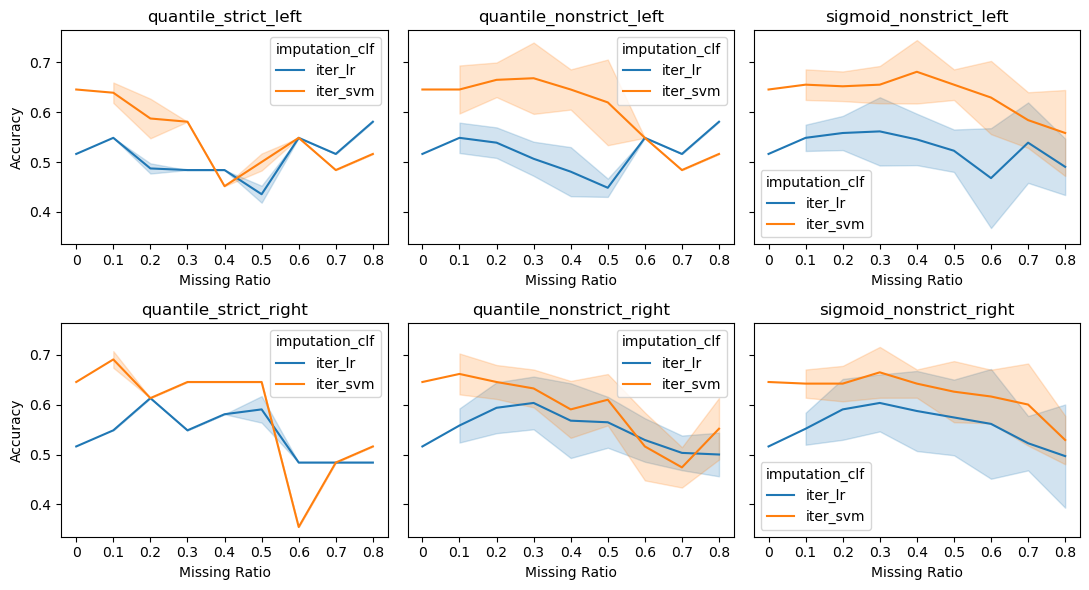

In [44]:
draw_plot_mar('glass', 'mar')

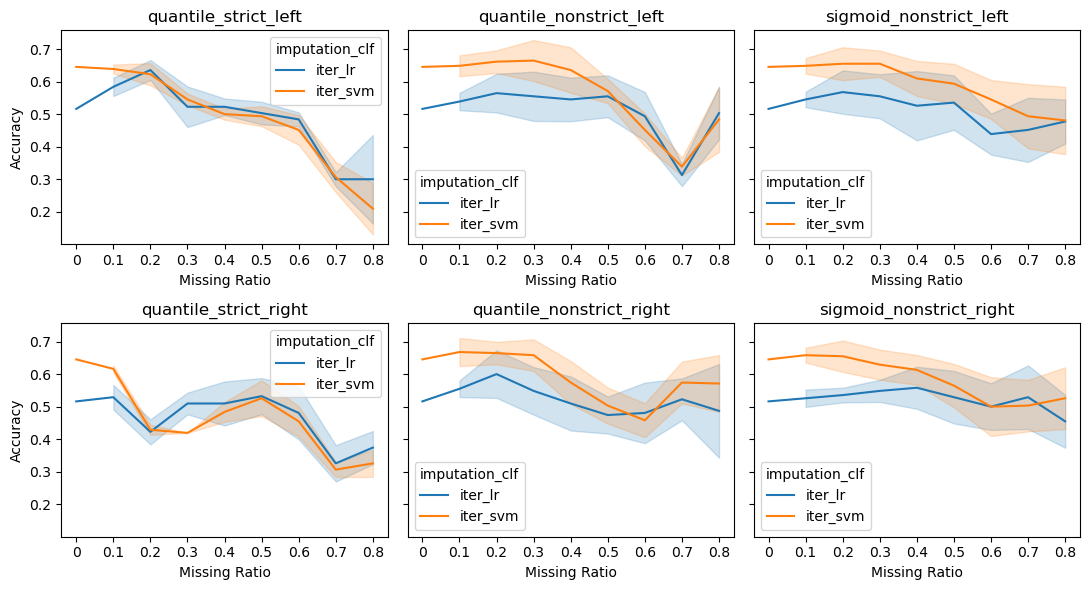

In [46]:
draw_plot_mar('glass', 'mary')

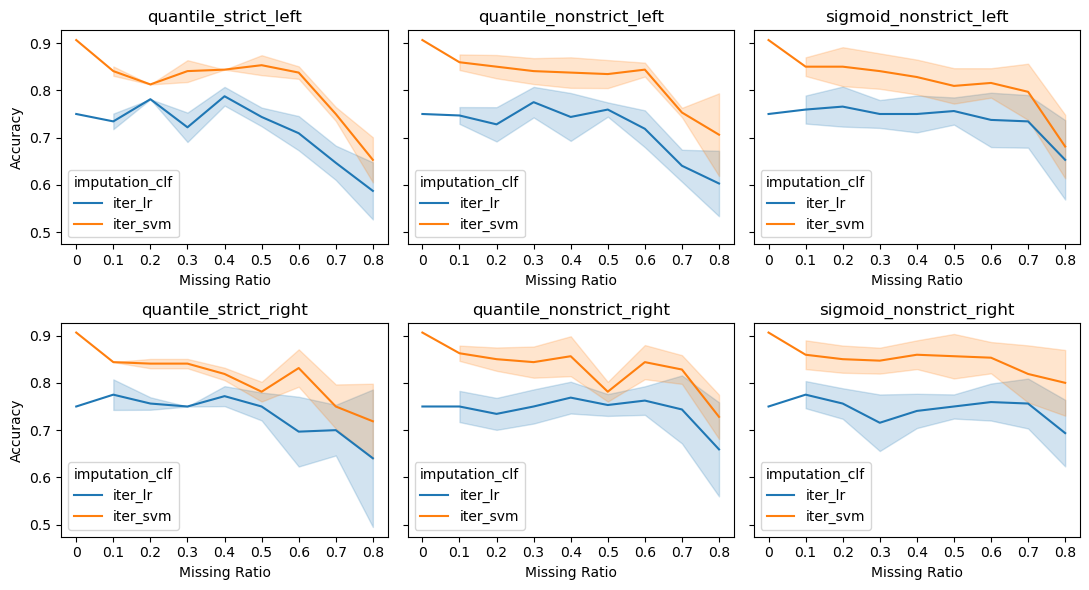

In [47]:
draw_plot_mar('sonar', 'mar')

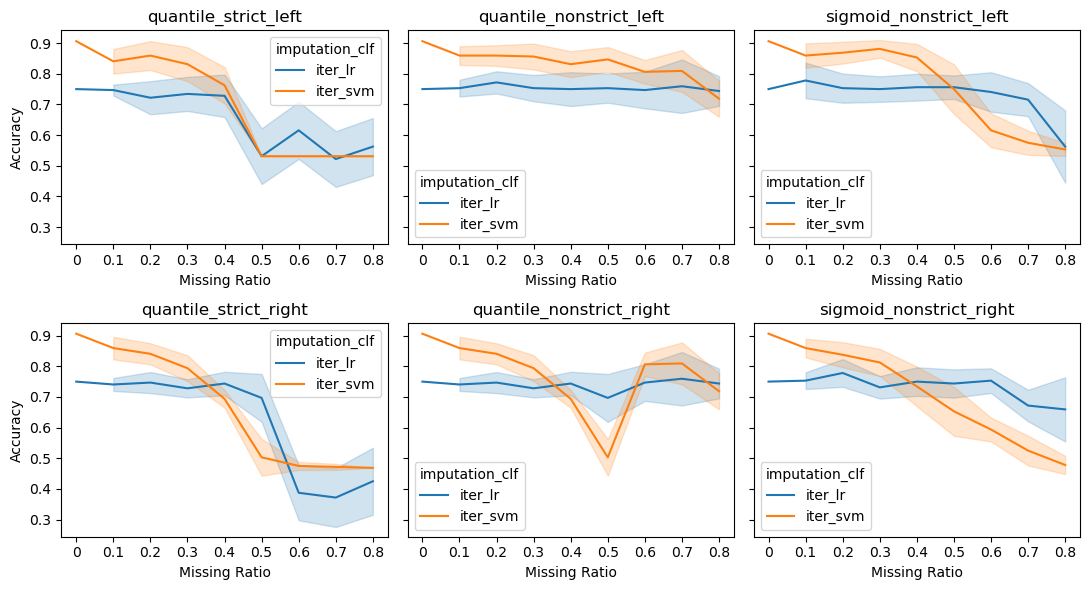

In [48]:
draw_plot_mar('sonar', 'mary')

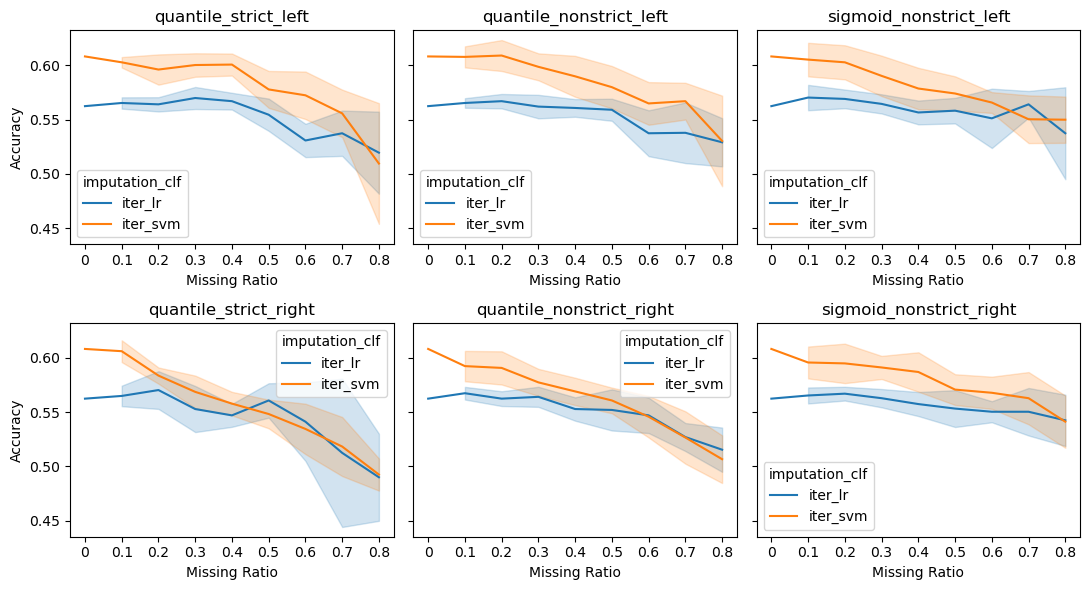

In [49]:
draw_plot_mar('red', 'mar')

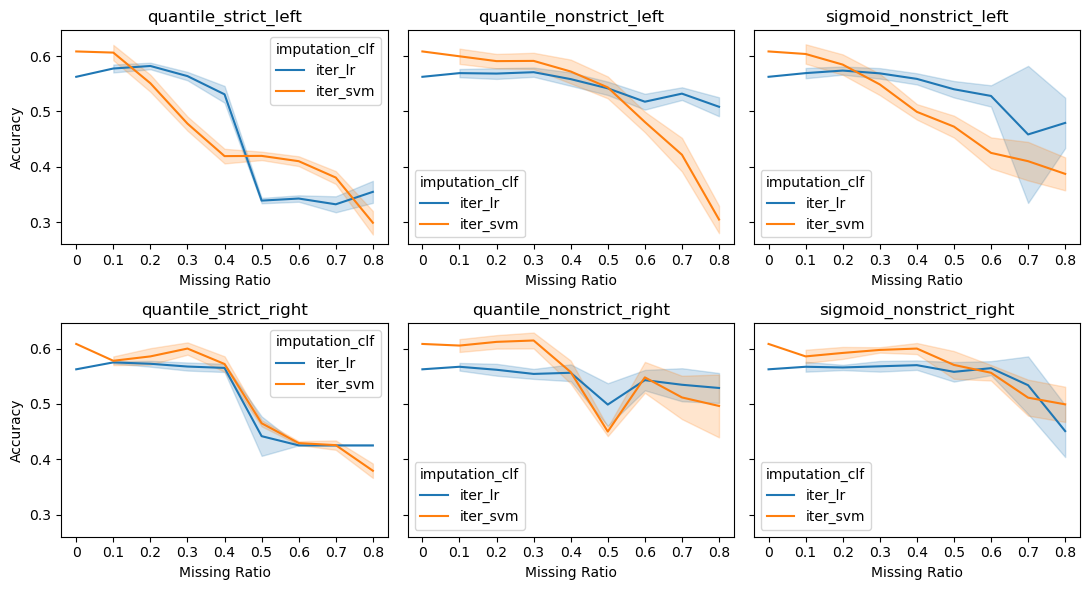

In [50]:
draw_plot_mar('red', 'mary')

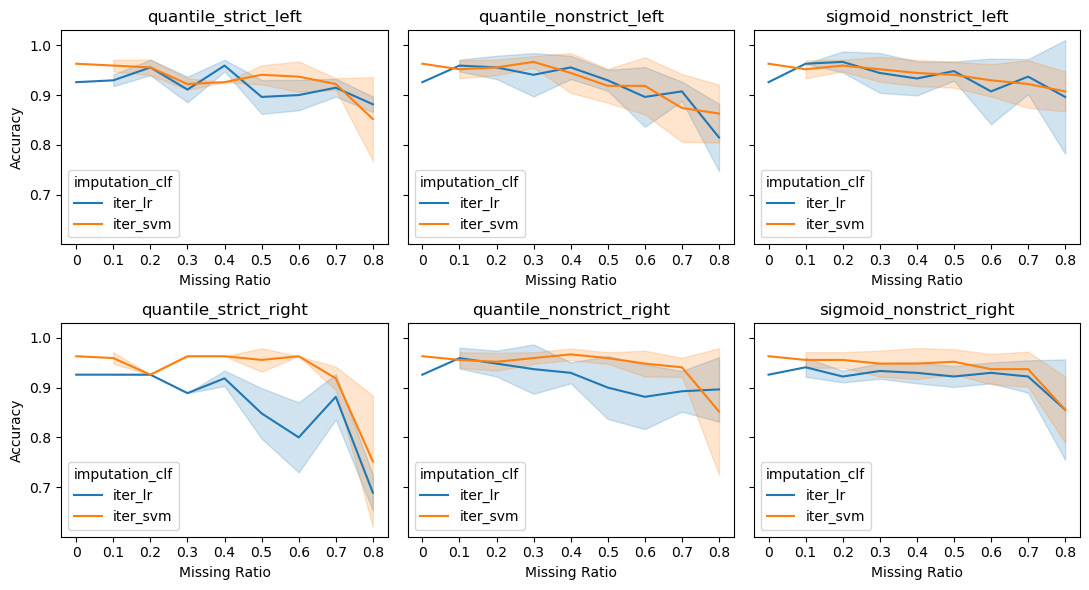

In [51]:
draw_plot_mar('wine', 'mar')

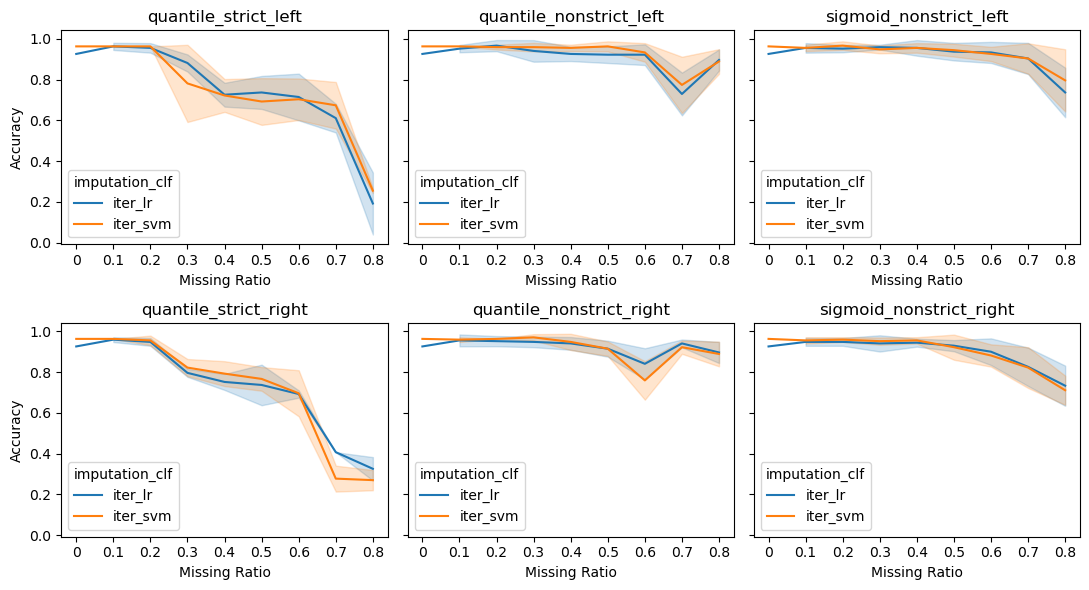

In [52]:
draw_plot_mar('wine', 'mary')

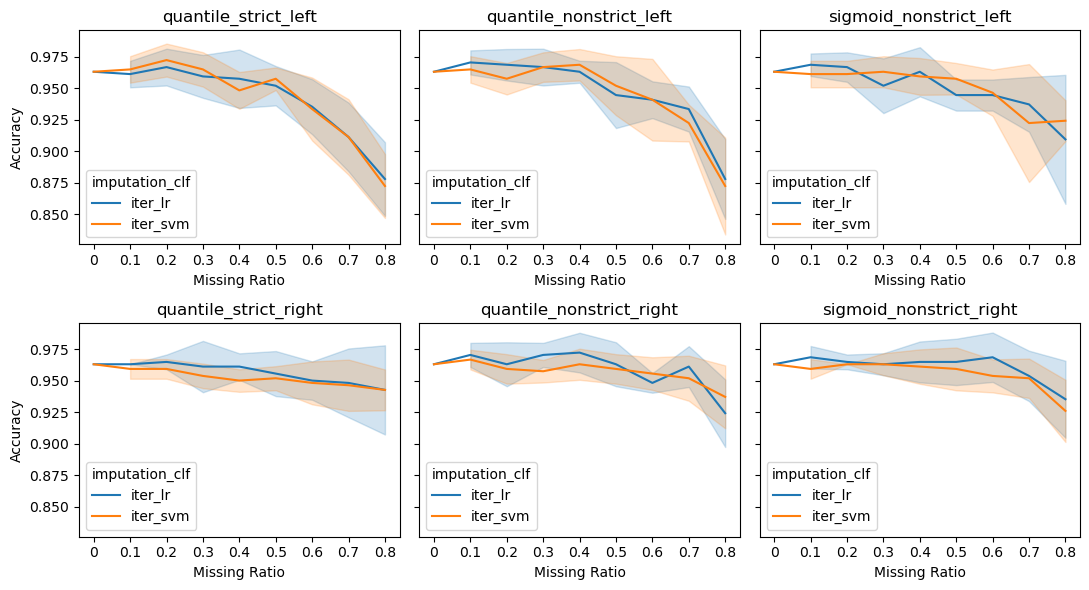

In [54]:
draw_plot_mar('dermatology', 'mar')

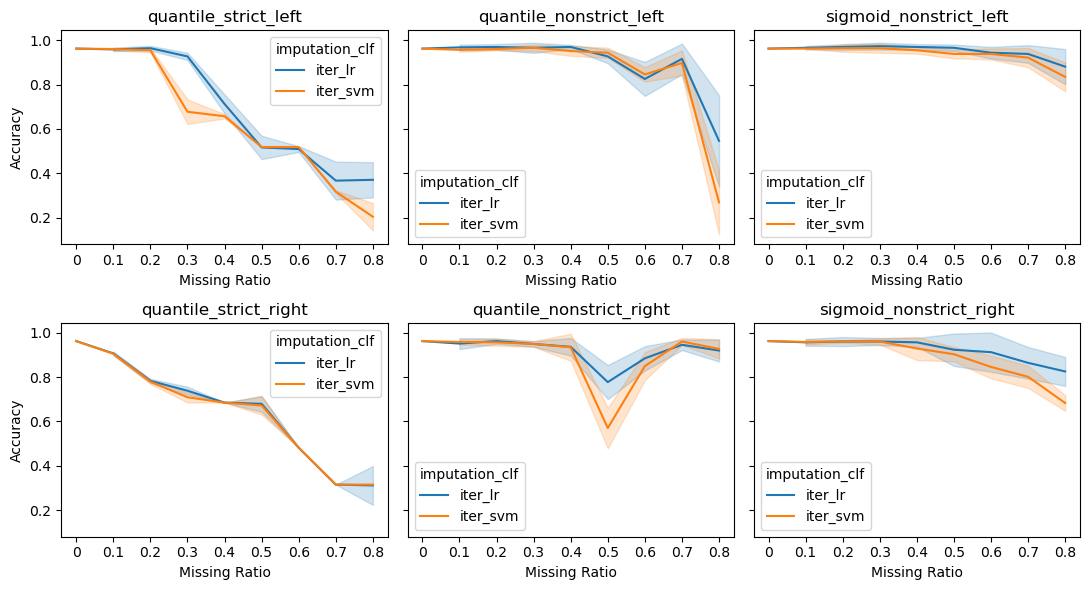

In [55]:
draw_plot_mar('dermatology', 'mary')